# Open-set Wafer Map Triage (WM-811K)

- **MVP-1(완료)**: Known 분류 + OOD(Unknown 탐지, MSP/Energy) 평가  
- **MVP-2(진행중)**: 트리아지(UMAP 시각화 + Top-K 유사사례 검색)

> 핵심: Unknown을 “Unknown”으로 거부(reject)하고, 이후 판단을 돕는 트리아지 워크플로우

## 0. 환경 설정
- Google Drive 마운트, 경로/시드 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

한글 폰트 깨지지 않게 설정

In [ ]:
import os, pathlib
os.environ["MPLCONFIGDIR"] = "/tmp/matplotlib"
pathlib.Path(os.environ["MPLCONFIGDIR"]).mkdir(parents=True, exist_ok=True)

!apt-get -qq update
!apt-get -qq -y install fonts-nanum fonts-noto-cjk
!fc-cache -fv

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
plt.rcParams["axes.unicode_minus"] = False

모델 저장 및 로드를 위해 미리 선언하는 셀

In [ ]:
import os, json
from datetime import datetime
import torch
import torchvision.models as models
import torch.nn as nn

INPUT_MODE = "polar4"  # <-- 과거 모델 분석 시 "repeat3", "coords4"로 바꾸면 됨
RANDOM_STATE = 42
CKPT_DIR = "/content/drive/MyDrive/Colab Notebooks/WMI_Wafer_DefectPattern_Detection_AnomalyAnalysis/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

def _safe(s: str) -> str:
    return (
        str(s).replace(" ", "")
        .replace("/", "-").replace("\\", "-")
        .replace(",", "-").replace("[", "").replace("]", "")
        .replace("'", "").replace('"', "")
    )

def _infer_in_chans_from_state_dict(sd):
    if "conv1.weight" in sd:
        return int(sd["conv1.weight"].shape[1])
    return 3

def _infer_input_mode(in_chans: int):
    if in_chans == 4:
        return INPUT_MODE #"coords4"
    if in_chans == 3:
        return "repeat3"
    return f"in{in_chans}"

def build_resnet18(num_classes: int, in_chans: int = 3):
    model = models.resnet18(weights=None)
    if in_chans != 3:
        model.conv1 = nn.Conv2d(in_chans, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def save_mvp_checkpoint(
    model,
    class_to_idx,
    unknown_classes,
    resize=64,
    arch="resnet18",
    optimizer=None,
    metrics=None,
    tag=None,
    extra=None,
):
    in_chans = int(model.conv1.in_channels) if hasattr(model, "conv1") else None
    input_mode = _infer_input_mode(in_chans if in_chans is not None else 3)

    ckpt = {
        "arch": arch,
        "resize": int(resize),
        "unknown_classes": list(unknown_classes),
        "class_to_idx": dict(class_to_idx),
        "model_in_chans": in_chans,
        "input_mode": input_mode,
        "metrics": metrics or {},
        "extra": extra or {},
        "model_state_dict": model.state_dict(),
    }
    if optimizer is not None:
        ckpt["optimizer_state_dict"] = optimizer.state_dict()

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    tag_s = _safe(tag) if tag else "ckpt"
    fname = f"{ts}_{arch}_R{resize}_{input_mode}_K{len(class_to_idx)}_{tag_s}.pt"
    path = os.path.join(CKPT_DIR, fname)
    torch.save(ckpt, path)
    print("✅ Saved:", path)
    return path

def load_mvp_checkpoint_auto(path, device="cpu", strict=False):
    ckpt = torch.load(path, map_location=device)

    class_to_idx = ckpt["class_to_idx"]
    known_classes = [None] * len(class_to_idx)
    for cls, idx in class_to_idx.items():
        known_classes[idx] = cls

    sd = ckpt["model_state_dict"]
    in_chans = ckpt.get("model_in_chans")
    if in_chans is None:
        in_chans = _infer_in_chans_from_state_dict(sd)

    input_mode = ckpt.get("input_mode") or _infer_input_mode(in_chans)
    resize = int(ckpt.get("resize", 64))

    arch = ckpt.get("arch", "resnet18")
    if arch != "resnet18":
        raise ValueError(f"Unsupported arch: {arch}")

    model = build_resnet18(num_classes=len(known_classes), in_chans=in_chans)
    missing, unexpected = model.load_state_dict(sd, strict=strict)

    model = model.to(device).eval()

    cfg = {
        "arch": arch,
        "resize": resize,
        "in_chans": in_chans,
        "input_mode": input_mode,
        "unknown_classes": ckpt.get("unknown_classes", []),
    }

    print("✅ Loaded:", path)
    print(" - cfg:", cfg)
    if missing:
        print(" - missing keys:", missing[:10], "..." if len(missing) > 10 else "")
    if unexpected:
        print(" - unexpected keys:", unexpected[:10], "..." if len(unexpected) > 10 else "")

    return model, ckpt, known_classes, class_to_idx, cfg

## 1. 데이터 로드 및 확인

In [ ]:
import pandas as pd

df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/WMI_Wafer_DefectPattern_Detection_AnomalyAnalysis/data/LSWMD.pkl")
print(df.shape)
print(df["failureType"].head())      # 보통 list 형태거나 빈 list
print(df["trianTestLabel"].head())   # 기존 train/test 표기가 있을 수 있음(우리는 재분할 권장)

### 1.1 데이터 구조 확인

In [ ]:
print(df.columns)
print(df[["waferMap","failureType","trianTestLabel"]].head(3))

# waferMap 한 개의 형태 확인
wm0 = df["waferMap"].iloc[0]
print(type(wm0), getattr(wm0, "shape", None))

### 1.2 라벨 전처리 (failureType → label)

In [ ]:
import numpy as np

def get_label(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return str(x[0][0]) if len(x) > 0 else None
    if isinstance(x, str) and x.strip() != "":
        return x
    return None

df["label"] = df["failureType"].apply(get_label)

print(df["label"].value_counts(dropna=False).head(15))
print("labeled count:", df["label"].notna().sum())

In [ ]:
print(type(df.iloc[0]["label"]))

## 2. Open-set 평가 설계 (클래스 홀드아웃)
- Donut과 Scratch를 Unknown(홀드아웃)으로 설정

In [ ]:
UNKNOWN_CLASSES = ["Donut", "Scratch"]
EXCLUDE_CLASSES = ["none"]

labeled = df[df["label"].notna()].copy()
labeled = labeled[~labeled["label"].isin(EXCLUDE_CLASSES)].copy()

known_df = labeled[~labeled["label"].isin(UNKNOWN_CLASSES)].copy()
unknown_df = labeled[labeled["label"].isin(UNKNOWN_CLASSES)].copy()

print("labeled:", len(labeled))
print("known:", len(known_df))
print("unknown:", len(unknown_df))
print("known classes:", sorted(known_df["label"].unique()))
print("unknown classes:", sorted(unknown_df["label"].unique()))

## 3. 클래스 이해 및 시각화

### 3.1 클래스 정의 + 컬러 의미


- **Center**: 웨이퍼 **중심(가운데)**에 불량이 몰려 있는 패턴 (가운데 뭉침)
- **Donut**: 중심은 비교적 깨끗하고, 그 주변에 **동심원(도넛 링)**처럼 불량이 분포 (원형 띠)
- **Edge-Loc (Edge-Local)**: 웨이퍼 **가장자리의 특정 구간**에만 불량이 몰린 패턴 (테두리 한쪽만)
- **Edge-Ring**: 웨이퍼 **테두리 전체를 따라 고리(링)**처럼 불량이 나타나는 패턴 (둘레 전체 띠)
- **Loc (Local)**: 웨이퍼 내부에서 **중심/테두리가 아닌 임의 위치**에 불량이 뭉친 패턴 (안쪽 어딘가 덩어리)
- **Random**: 웨이퍼 전체에 불량이 **듬성듬성, 비교적 고르게 흩어진** 패턴 (여기저기 점)
- **Scratch**: **직선/곡선 형태로 길게 이어진** 불량 패턴 (긁힌 자국처럼 선/호)
- **Near-full**: 웨이퍼 **거의 전체가 불량으로 채워진** 패턴 (대부분 불량)
- **none**: 뚜렷한 결함 패턴이 없거나 결함이 거의 없는 상태 (패턴 없음)
---
- 보라(가장 어두운 색) = 작은 값 (보통 0) → 웨이퍼 바깥/배경
- 파랑(중간 값) = 중간 값 (보통 1) → 정상 die (pass)
- 노랑(가장 밝은 색) = 큰 값 (보통 2) → 불량 die (fail)

### 3.2 클래스별 대표 1장 그리드로 보기

In [ ]:
import matplotlib.pyplot as plt

labels = sorted(labeled["label"].unique())
n = len(labels)

cols = 4
rows = (n + cols - 1) // cols

plt.figure(figsize=(4*cols, 4*rows))
for i, lab in enumerate(labels):
    wm = labeled[labeled["label"] == lab]["waferMap"].iloc[0]  # 첫 샘플
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(wm, interpolation="nearest")
    ax.set_title(lab)
    ax.axis("off")
plt.tight_layout()
plt.show()

### 3.3 특정 Failure Type 랜덤 샘플 보기

In [ ]:
import matplotlib.pyplot as plt

def show_samples(label, n=8, seed=RANDOM_STATE):
    sub = labeled[labeled["label"] == label]
    if len(sub) == 0:
        print("No samples for:", label)
        return
    sub = sub.sample(n=min(n, len(sub)), random_state=seed)

    cols = 4
    rows = (len(sub) + cols - 1) // cols
    plt.figure(figsize=(4*cols, 4*rows))
    for i, wm in enumerate(sub["waferMap"].tolist()):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(wm, interpolation="nearest")
        ax.axis("off")
    plt.suptitle(f"{label} (n={len(sub)})", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# 예시
for label in ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Random", "Scratch", "Near-full", "none"]:
    show_samples(label, n=8, seed=0)

## 4. 데이터 분할 (train/val/test_known/test_unknown)

- train = 70%
- val = 15%
- test_known = 15%
- test_unknown = unknown_df 전부

이 비율은 머신러닝에서 아주 흔한 기본값

- train을 충분히 크게 가져가야 학습이 잘 되고
- val/test도 너무 작으면 지표가 흔들리니까 적당히 확보하는 균형

In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    known_df, test_size=0.3, random_state=RANDOM_STATE, stratify=known_df["label"] # stratify는 각 split마다 라벨 비율이 원래 데이터랑 비슷하게 유지되도록 나눠주는 옵션
)
val_df, test_known_df = train_test_split(
    temp_df, test_size=0.5, random_state=RANDOM_STATE, stratify=temp_df["label"]
)

test_unknown_df = unknown_df.copy()

print("train:", len(train_df), "val:", len(val_df),
      "test_known:", len(test_known_df), "test_unknown:", len(test_unknown_df))

## 5. Dataset/DataLoader 구성 (전처리/증강)


*   waferMap을 64×64로 resize
*   1채널을 3채널로 복제해서 ResNet에 넣기 (가장 쉬운 방식)
*   회전/반전 증강은 train에만

In [ ]:
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# ✅ class_to_idx는 "현재 train_df에서 새로 만들지 말고"
#    분석하려는 ckpt에서 로드한 class_to_idx를 쓰는 게 원칙.
#    (단, 지금 학습하는 모드면 아래처럼 train_df 기반 생성 OK)
known_classes = sorted(train_df["label"].unique())
class_to_idx = {c:i for i,c in enumerate(known_classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
print(class_to_idx)

def _make_polar_grid_and_pos(resize: int, device="cpu", dtype=torch.float32):
    """
    output: (polar_grid[1,H,W,2], pos[3,H,W])
    - polar_grid: grid_sample용 (x,y) in [-1,1]
    - pos: [r, sin(theta), cos(theta)] 채널
    """
    H = W = resize
    r = torch.linspace(0.0, 1.0, H, device=device, dtype=dtype)                 # (H,)
    theta = torch.linspace(-math.pi, math.pi, W, device=device, dtype=dtype)     # (W,)

    rr = r[:, None].expand(H, W)             # (H,W)
    tt = theta[None, :].expand(H, W)         # (H,W)

    xx = rr * torch.cos(tt)                  # (H,W)
    yy = rr * torch.sin(tt)                  # (H,W)

    grid = torch.stack([xx, yy], dim=-1)     # (H,W,2)
    grid = grid.unsqueeze(0)                 # (1,H,W,2)  grid_sample expects N,H,W,2

    pos = torch.stack([rr, torch.sin(tt), torch.cos(tt)], dim=0)  # (3,H,W)
    return grid, pos

class WaferMapDataset(Dataset):
    def __init__(self, df, class_to_idx=None, is_train=False, resize=64, input_mode="coords4", return_idx=False):
        self.df = df.reset_index(drop=True)
        self.class_to_idx = class_to_idx
        self.is_train = is_train
        self.resize = int(resize)
        self.input_mode = input_mode
        self.return_idx = return_idx

        # polar4 모드일 때만 polar grid/pos 채널 생성
        if self.input_mode == "polar4":
            self.polar_grid, self.polar_pos = _make_polar_grid_and_pos(self.resize)

        # coords4 모드일 때만 좌표 채널 생성
        if self.input_mode == "coords4":
            g = torch.linspace(-1, 1, self.resize)
            try:
                yy, xx = torch.meshgrid(g, g, indexing="ij")
            except TypeError:
                yy, xx = torch.meshgrid(g, g)
            rr = torch.sqrt(xx**2 + yy**2)
            self.coords = torch.stack([xx, yy, rr], dim=0).float()  # (3,R,R)

    def __len__(self):
        return len(self.df)

    def _augment(self, x):
        # x: (C,H,W)
        if self.input_mode == "polar4":
            # 회전 불변성: theta축 circular shift (rotation == shift)
            if torch.rand(()) < 0.9:
                shift = int(torch.randint(0, self.resize, ()).item())
                x = torch.roll(x, shifts=shift, dims=-1)
            # 좌우 반사(선택): theta reverse
            if torch.rand(()) < 0.5:
                x = torch.flip(x, dims=[-1])
            return x

        # (기존 coords4/repeat3 쪽 augment가 있으면 여기에 유지)
        # 최소 안전 버전: 아무것도 안 함
        return x

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # waferMap -> (1,H,W) float
        wm = torch.as_tensor(row["waferMap"], dtype=torch.float32)  # (h,w)
        wm = wm.unsqueeze(0).unsqueeze(0)                           # (1,1,h,w)

        # resize (원래 discrete 값이면 nearest 권장)
        if wm.shape[-1] != self.resize or wm.shape[-2] != self.resize:
            wm = F.interpolate(wm, size=(self.resize, self.resize), mode="nearest")
        wm = wm.squeeze(0)  # (1,R,R)

        # 입력 모드별 채널 구성
        if self.input_mode == "polar4":
          # ✅ (중요) waferMap은 사실상 이산값이므로 먼저 정수화/마스크화
          wm_int = wm.round()  # (1,R,R)  값이 0/1/2로 유지되게
          defect = (wm_int == 2).float()  # 결함만 1, 나머지 0  -> (1,R,R)

          # ✅ (중요) bilinear로 섞이면 선/점 패턴이 흐려짐 → nearest
          polar_defect = F.grid_sample(
              defect.unsqueeze(0),         # (1,1,R,R)
              self.polar_grid,             # (1,R,R,2)
              mode="nearest",
              padding_mode="zeros",
              align_corners=True,
          ).squeeze(0)                     # (1,R,R)

          # 입력: [결함마스크(1) + (r,sinθ,cosθ)(3)] = 4채널
          x = torch.cat([polar_defect, self.polar_pos], dim=0)  # (4,R,R)

        elif self.input_mode == "coords4":
            x = wm                                   # (1,R,R)
            x = torch.cat([x, self.coords], dim=0)   # (4,R,R)

        elif self.input_mode == "repeat3":
            x = wm.repeat(3, 1, 1)                   # (3,R,R)

        else:
            raise ValueError(f"Unknown input_mode: {self.input_mode}")

        if self.is_train:
            x = self._augment(x)

        # label
        if self.class_to_idx is None:
            return (x, idx) if self.return_idx else x

        y = self.class_to_idx[row["label"]]
        return (x, y, idx) if self.return_idx else (x, y)


# ✅ 여기서 INPUT_MODE를 모델 cfg에 맞춰 바꿔 끼울 수 있어야 함
# (학습 중이면 coords4로 고정해도 되지만, '과거 ckpt 분석'까지 하려면 아래처럼 변수화)
RESIZE = 64

train_loader = DataLoader(
    WaferMapDataset(train_df, class_to_idx, True, 64, INPUT_MODE),
    batch_size=128, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    WaferMapDataset(val_df, class_to_idx, False, 64, INPUT_MODE),
    batch_size=256, shuffle=False, num_workers=2
)
test_known_loader = DataLoader(
    WaferMapDataset(test_known_df, class_to_idx, False, 64, INPUT_MODE),
    batch_size=256, shuffle=False, num_workers=2
)
test_unknown_loader = DataLoader(
    WaferMapDataset(test_unknown_df, class_to_idx=None, is_train=False, resize=64, input_mode=INPUT_MODE),
    batch_size=256, shuffle=False, num_workers=2
)

## 6. Known 분류기 학습 (ResNet18 베이스라인)

In [ ]:
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(weights=None)
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, len(known_classes))
model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train=True, return_preds=False):
    model.train(train)
    total_loss, correct, total = 0.0, 0, 0
    ys, ps = [], []

    for x, y in tqdm(loader, disable=not train):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

        if return_preds:
            ys.append(y.detach().cpu().numpy())
            ps.append(pred.detach().cpu().numpy())

    if return_preds:
        import numpy as np
        y_true = np.concatenate(ys)
        y_pred = np.concatenate(ps)
        return total_loss/total, correct/total, y_true, y_pred

    return total_loss/total, correct/total

best_val_macro = -1.0
best_path = None

EPOCHS = 5
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc, yv, pv = run_epoch(val_loader, train=False, return_preds=True)

    va_macro = f1_score(yv, pv, average="macro")
    print(f"Epoch {epoch} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f} macroF1 {va_macro:.4f}")

    # (선택) best 저장
    if va_macro > best_val_macro:
        best_val_macro = va_macro
        best_path = save_mvp_checkpoint(
            model=model,
            class_to_idx=class_to_idx,
            unknown_classes=UNKNOWN_CLASSES,
            resize=64,
            arch="resnet18",
            optimizer=opt,
            metrics={"epoch": epoch, "val_acc": va_acc, "val_macro_f1": va_macro},
            tag=f"best_e{epoch:02d}"
        )

# (필수) 학습 끝나면 last 저장
last_path = save_mvp_checkpoint(
    model=model,
    class_to_idx=class_to_idx,
    unknown_classes=UNKNOWN_CLASSES,
    resize=64,
    arch="resnet18",
    optimizer=opt,
    metrics={"epoch": EPOCHS, "val_acc": va_acc, "val_macro_f1": best_val_macro},
    tag=f"last_e{EPOCHS:02d}"
)

print("✅ Saved best:", best_path)
print("✅ Saved last:", last_path)

## 7. Known 성능 평가 (macro-F1 중심)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import torch.nn.functional as F

@torch.no_grad()
def predict_known(loader):
    model.eval()
    ys, ps = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1).cpu().numpy()
        ys.append(np.array(y))
        ps.append(pred)
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    return y_true, y_pred

y_true, y_pred = predict_known(test_known_loader)
print("macro-F1:", f1_score(y_true, y_pred, average="macro"))
print(classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(len(known_classes))]))

### 7.1 confusion matrix + “Loc이 어디로 새는지 / Random이 누구를 잡아먹는지 확인


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix

labels = known_classes  # ["Center", "Edge-Loc", ...] (이미 정렬돼 있음)
n = len(labels)

# 1) Confusion matrix (raw + row-normalized)
cm = confusion_matrix(y_true, y_pred, labels=list(range(n)))
cm_row = cm / np.clip(cm.sum(axis=1, keepdims=True), 1, None)

plt.figure(figsize=(8, 6))
plt.imshow(cm_row, vmin=0, vmax=1)
plt.xticks(range(n), labels, rotation=45, ha="right")
plt.yticks(range(n), labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (row-normalized)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 2) 클래스별로 '가장 많이 틀리는 방향' Top-k 출력
def top_confusions(cm, labels, k=3):
    for i, lab in enumerate(labels):
        row = cm[i].copy()
        row[i] = 0
        total = cm[i].sum()
        if total == 0:
            continue
        top = np.argsort(row)[::-1][:k]
        print(f"\nTrue {lab} (n={total})")
        for j in top:
            if row[j] == 0:
                continue
            print(f"  -> Pred {labels[j]}: {row[j]} ({row[j]/total:.1%})")

top_confusions(cm, labels, k=3)

# 3) Loc(재현율 낮음) / Random(precision 낮음) 집중 분석
loc_idx = class_to_idx["Loc"]
rand_idx = class_to_idx["Random"]

# Loc 미탐: True=Loc인데 Pred!=Loc
loc_miss = np.where((y_true == loc_idx) & (y_pred != loc_idx))[0]
print("\n[Loc misses]")
print("  count:", len(loc_miss), "/", int((y_true == loc_idx).sum()), f"= {len(loc_miss)/max(1,(y_true==loc_idx).sum()):.1%}")

miss_to = y_pred[loc_miss]
vals, cnts = np.unique(miss_to, return_counts=True)
for v, c in sorted(zip(vals, cnts), key=lambda x: -x[1]):
    print(f"  Loc -> {idx_to_class[int(v)]}: {c} ({c/len(loc_miss):.1%})")

# Random 오탐: Pred=Random인데 True!=Random
rand_fp = np.where((y_pred == rand_idx) & (y_true != rand_idx))[0]
print("\n[Random false positives]")
print("  count:", len(rand_fp), "/", int((y_pred == rand_idx).sum()), f"= {len(rand_fp)/max(1,(y_pred==rand_idx).sum()):.1%}")

fp_from = y_true[rand_fp]
vals, cnts = np.unique(fp_from, return_counts=True)
for v, c in sorted(zip(vals, cnts), key=lambda x: -x[1]):
    print(f"  True {idx_to_class[int(v)]} -> Random: {c} ({c/len(rand_fp):.1%})")

# 4) 실제 웨이퍼맵으로 눈으로 확인 (Loc miss / Random FP)
test_known_df_r = test_known_df.reset_index(drop=True).copy()

def show_cases(idxs, title="", n_show=12, cols=4):
    idxs = list(idxs)[:n_show]
    if len(idxs) == 0:
        print(title, ": (none)")
        return
    rows = math.ceil(len(idxs)/cols)
    plt.figure(figsize=(4*cols, 4*rows))
    for i, idx in enumerate(idxs):
        row = test_known_df_r.iloc[int(idx)]
        wm = row["waferMap"]
        true_lab = row["label"]
        pred_lab = idx_to_class[int(y_pred[int(idx)])]
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(wm, interpolation="nearest")
        ax.set_title(f"T:{true_lab}\nP:{pred_lab}", fontsize=10)
        ax.axis("off")
    plt.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

show_cases(loc_miss, title="Loc misclassified (True=Loc, Pred!=Loc)", n_show=12)
show_cases(rand_fp, title="Random false positives (Pred=Random, True!=Random)", n_show=12)

### 7.1 Random threshold 스윕

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

# ===== 0) model / device 확보 (너 노트북 스타일 그대로) =====
device = "cuda" if torch.cuda.is_available() else "cpu"
model = loaded_model if "loaded_model" in globals() else model
model = model.to(device).eval()

assert "Random" in class_to_idx, "known_classes에 'Random'이 없어. (Random 임계값 스윕 불가)"
rand_idx = class_to_idx["Random"]

# ===== 1) 확률(probs), argmax 예측, 정답 얻기 =====
@torch.no_grad()
def get_probs_and_preds(model, loader, device):
    model.eval()
    all_probs, all_pred, all_true = [], [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_pred.append(probs.argmax(dim=1).cpu().numpy())
        all_true.append(np.array(y))
    probs = np.concatenate(all_probs, axis=0)
    y_pred = np.concatenate(all_pred, axis=0)
    y_true = np.concatenate(all_true, axis=0)
    return probs, y_pred, y_true

def apply_random_threshold(probs, y_pred_argmax, rand_idx, t_rand: float):
    """
    argmax가 Random인데 Random 확률이 t_rand 미만이면 2등 클래스로 보냄
    """
    y2 = y_pred_argmax.copy()
    rand_mask = (y_pred_argmax == rand_idx) & (probs[:, rand_idx] < t_rand)
    if rand_mask.any():
        second = np.argsort(probs[rand_mask], axis=1)[:, -2]
        y2[rand_mask] = second
    return y2, int(rand_mask.sum())

def plot_cm_row_norm(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    cm_row = cm / np.clip(cm.sum(axis=1, keepdims=True), 1, None)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm_row, vmin=0, vmax=1)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (row-normalized)")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# ===== 2) VAL에서 t_rand 스윕 =====
probs_val, pred_val, y_val = get_probs_and_preds(model, val_loader, device)

base_macro = f1_score(y_val, pred_val, average="macro")
base_acc = accuracy_score(y_val, pred_val)

ts = np.arange(0.50, 0.91, 0.05)  # 필요하면 0.02 간격 등으로 촘촘히 바꿔도 됨
rows = []
for t in ts:
    pred_val2, moved = apply_random_threshold(probs_val, pred_val, rand_idx, float(t))
    rows.append({
        "t_rand": float(t),
        "moved_from_random": moved,
        "val_acc": float(accuracy_score(y_val, pred_val2)),
        "val_macro_f1": float(f1_score(y_val, pred_val2, average="macro")),
        "val_macro_f1_gain": float(f1_score(y_val, pred_val2, average="macro") - base_macro),
    })

sweep_df = pd.DataFrame(rows).sort_values("val_macro_f1", ascending=False).reset_index(drop=True)

print(f"[VAL baseline] acc={base_acc:.4f}, macroF1={base_macro:.4f}")
display(sweep_df.head(10))

best_t = float(sweep_df.loc[0, "t_rand"])
print("\n✅ best_t (by val macro-F1):", best_t)

# ===== 3) TEST_KNOWN에 best_t 적용 (전/후 리포트) =====
probs_test, pred_test, y_test = get_probs_and_preds(model, test_known_loader, device)

print("\n[TEST baseline]")
print("macro-F1:", f1_score(y_test, pred_test, average="macro"))
print(classification_report(y_test, pred_test, target_names=[idx_to_class[i] for i in range(len(known_classes))]))

pred_test2, moved = apply_random_threshold(probs_test, pred_test, rand_idx, best_t)

print("\n[TEST after Random-threshold]")
print("moved_from_random:", moved)
print("macro-F1:", f1_score(y_test, pred_test2, average="macro"))
print(classification_report(y_test, pred_test2, target_names=[idx_to_class[i] for i in range(len(known_classes))]))

# (선택) after CM도 같이 보기
plot_cm_row_norm(y_test, pred_test2, [idx_to_class[i] for i in range(len(known_classes))])

## 8. OOD(Unknown 탐지) 평가: MSP vs Energy

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

@torch.no_grad()
def collect_scores(loader, known=True, T=1.0):
    model.eval()
    msp_list, energy_list = [], []
    for batch in loader:
        x = batch[0] if known else batch
        x = x.to(device)

        logits = model(x) / T
        prob = torch.softmax(logits, dim=1)
        msp = prob.max(dim=1).values                   # 높을수록 known
        energy = -T * torch.logsumexp(logits, dim=1)   # 보통 -energy가 높을수록 known로 사용

        msp_list.append(msp.cpu().numpy())
        energy_list.append(energy.cpu().numpy())

    return np.concatenate(msp_list), np.concatenate(energy_list)

msp_k, en_k = collect_scores(test_known_loader, known=True)
msp_u, en_u = collect_scores(test_unknown_loader, known=False)

y = np.concatenate([np.ones_like(msp_k), np.zeros_like(msp_u)])  # known=1, unknown=0

score_msp = np.concatenate([msp_k, msp_u])
score_energy = np.concatenate([-en_k, -en_u])  # -energy를 known 점수로

print("AUROC MSP   :", roc_auc_score(y, score_msp))
print("AUPR  MSP   :", average_precision_score(y, score_msp))
print("AUROC Energy:", roc_auc_score(y, score_energy))
print("AUPR  Energy:", average_precision_score(y, score_energy))

## 9. 체크포인트 로드


저장된 `state_dict`를 불러와 새로운 모델 인스턴스에 로드합니다. 이때, 모델의 아키텍처는 저장할 때와 동일하게 정의되어 있어야 합니다.

저장은 필요하면 아래 코드 실행

In [ ]:
ckpt_path = save_mvp_checkpoint(model, class_to_idx, UNKNOWN_CLASSES, resize=64, arch="resnet18", optimizer=None)

### Checkpoint만 로드

In [ ]:
import os, glob
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

CKPT_PATH = "/content/drive/MyDrive/Colab Notebooks/WMI_Wafer_DefectPattern_Detection_AnomalyAnalysis/checkpoints/20260110_105958_resnet18_R64_polar4_K6_best_e04.pt"

# CKPT_PATH 지정 안 했으면 최신 ckpt 자동 선택
if "CKPT_PATH" not in globals() or CKPT_PATH is None:
    ckpts = sorted(glob.glob(os.path.join(CKPT_DIR, "*.pt")))
    if len(ckpts) == 0:
        raise FileNotFoundError("No checkpoints found in CKPT_DIR")
    CKPT_PATH = ckpts[-1]

# 로드(자동 cfg 포함)
model, ckpt, known_classes_model, class_to_idx_model, MODEL_CFG = load_mvp_checkpoint_auto(CKPT_PATH, device=device)

# 분석용 공통 변수명으로 세팅(이미 있으면 덮어씀)
class_to_idx = class_to_idx_model
idx_to_class = {i:c for c,i in class_to_idx.items()}

known_classes = [None]*len(class_to_idx)
for c,i in class_to_idx.items():
    known_classes[i] = c

print("analysis classes:", known_classes)

print("READY ✅ (ckpt loaded)")
print(" - CKPT_PATH:", CKPT_PATH)
print(" - MODEL_CFG:", MODEL_CFG)

### 데이터/라벨/스플릿

In [ ]:
print(ckpt.get("unknown_classes"))
print(known_classes)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/WMI_Wafer_DefectPattern_Detection_AnomalyAnalysis/data/LSWMD.pkl"

UNKNOWN_CLASSES = ckpt.get("unknown_classes", ["Donut", "Scratch"])
EXCLUDE_CLASSES = [] if ("none" in ckpt.get("class_to_idx", {})) else ["none"]
print("UNKNOWN_CLASSES:", UNKNOWN_CLASSES)
print("EXCLUDE_CLASSES:", EXCLUDE_CLASSES)

def _to_label(x):
    if x is None:
        return None
    if isinstance(x, float) and np.isnan(x):
        return None

    # ndarray/list/tuple 안의 첫 원소를 scalar string까지 벗김
    for _ in range(5):
        if isinstance(x, np.ndarray):
            if x.size == 0:
                return None
            x = x.ravel()[0]
            continue
        if isinstance(x, (list, tuple)):
            if len(x) == 0:
                return None
            x = x[0]
            continue
        break

    if isinstance(x, np.generic):
        x = x.item()

    if isinstance(x, str):
        x = x.strip()
        return x if x != "" else None

    return str(x)

# df 로드/label 생성 (skip)
if "df" not in globals() or df is None:
    print("Download origin data")
    df = pd.read_pickle(DATA_PATH)

if "label" not in df.columns:
    df["label"] = df["failureType"].apply(_to_label)

# splits 생성 (skip)
need_split = not all(k in globals() for k in ["train_df","val_df","test_known_df","test_unknown_df"])
if need_split:
    labeled = df[df["label"].notna()].copy()
    labeled = labeled[~labeled["label"].isin(EXCLUDE_CLASSES)].copy()

    known_all = labeled[~labeled["label"].isin(UNKNOWN_CLASSES)].copy()
    unknown_df = labeled[labeled["label"].isin(UNKNOWN_CLASSES)].copy()

    # stratify fallback
    try:
        train_df, temp_df = train_test_split(
            known_all, test_size=0.3, random_state=RANDOM_STATE, stratify=known_all["label"]
        )
        val_df, test_known_df = train_test_split(
            temp_df, test_size=0.5, random_state=RANDOM_STATE, stratify=temp_df["label"]
        )
    except ValueError as e:
        print("[Warn] Stratified split failed -> fallback:", e)
        train_df, temp_df = train_test_split(known_all, test_size=0.3, random_state=RANDOM_STATE, shuffle=True)
        val_df, test_known_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_STATE, shuffle=True)

    test_unknown_df = unknown_df.copy()

print("READY ✅ (data/split)")
print(" - train/val/test_known/test_unknown:", len(train_df), len(val_df), len(test_known_df), len(test_unknown_df))

## 10. 트리아지(MVP-2): 임베딩 기반 유사사례/시각화

### 10.1 트리아지용 Dataset (이미지 + 라벨 + row index)

[5. Dataset/DataLoader 구성 (전처리/증강)](https://colab.research.google.com/drive/1gs1u8PboIWySUJ-siTfmclQ26GcwqYCu#scrollTo=MDQQDaKPmpBM&line=4&uniqifier=1)에 학습된 모델을 불러와서 진행할 경우 정리된 class 호출 후, 진행

In [ ]:
from torch.utils.data import Dataset

def _make_polar_grid_and_pos(resize: int, device="cpu", dtype=torch.float32):
    """
    output: (polar_grid[1,H,W,2], pos[3,H,W])
    - polar_grid: grid_sample용 (x,y) in [-1,1]
    - pos: [r, sin(theta), cos(theta)] 채널
    """
    H = W = resize
    r = torch.linspace(0.0, 1.0, H, device=device, dtype=dtype)                 # (H,)
    theta = torch.linspace(-math.pi, math.pi, W, device=device, dtype=dtype)     # (W,)

    rr = r[:, None].expand(H, W)             # (H,W)
    tt = theta[None, :].expand(H, W)         # (H,W)

    xx = rr * torch.cos(tt)                  # (H,W)
    yy = rr * torch.sin(tt)                  # (H,W)

    grid = torch.stack([xx, yy], dim=-1)     # (H,W,2)
    grid = grid.unsqueeze(0)                 # (1,H,W,2)  grid_sample expects N,H,W,2

    pos = torch.stack([rr, torch.sin(tt), torch.cos(tt)], dim=0)  # (3,H,W)
    return grid, pos

class WaferMapDataset(Dataset):
    def __init__(self, df, class_to_idx=None, is_train=False, resize=64, input_mode="coords4", return_idx=False):
        self.df = df.reset_index(drop=True)
        self.class_to_idx = class_to_idx
        self.is_train = is_train
        self.resize = int(resize)
        self.input_mode = input_mode
        self.return_idx = return_idx

        # polar4 모드일 때만 polar grid/pos 채널 생성
        if self.input_mode == "polar4":
            self.polar_grid, self.polar_pos = _make_polar_grid_and_pos(self.resize)

        # coords4 모드일 때만 좌표 채널 생성
        if self.input_mode == "coords4":
            g = torch.linspace(-1, 1, self.resize)
            try:
                yy, xx = torch.meshgrid(g, g, indexing="ij")
            except TypeError:
                yy, xx = torch.meshgrid(g, g)
            rr = torch.sqrt(xx**2 + yy**2)
            self.coords = torch.stack([xx, yy, rr], dim=0).float()  # (3,R,R)

    def __len__(self):
        return len(self.df)

    def _augment(self, x):
        # x: (C,H,W)
        if self.input_mode == "polar4":
            # 회전 불변성: theta축 circular shift (rotation == shift)
            if torch.rand(()) < 0.9:
                shift = int(torch.randint(0, self.resize, ()).item())
                x = torch.roll(x, shifts=shift, dims=-1)
            # 좌우 반사(선택): theta reverse
            if torch.rand(()) < 0.5:
                x = torch.flip(x, dims=[-1])
            return x

        # (기존 coords4/repeat3 쪽 augment가 있으면 여기에 유지)
        # 최소 안전 버전: 아무것도 안 함
        return x

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # waferMap -> (1,H,W) float
        wm = torch.as_tensor(row["waferMap"], dtype=torch.float32)  # (h,w)
        wm = wm.unsqueeze(0).unsqueeze(0)                           # (1,1,h,w)

        # resize (원래 discrete 값이면 nearest 권장)
        if wm.shape[-1] != self.resize or wm.shape[-2] != self.resize:
            wm = F.interpolate(wm, size=(self.resize, self.resize), mode="nearest")
        wm = wm.squeeze(0)  # (1,R,R)

        # 입력 모드별 채널 구성
        if self.input_mode == "polar4":
          # ✅ (중요) waferMap은 사실상 이산값이므로 먼저 정수화/마스크화
          wm_int = wm.round()  # (1,R,R)  값이 0/1/2로 유지되게
          defect = (wm_int == 2).float()  # 결함만 1, 나머지 0  -> (1,R,R)

          # ✅ (중요) bilinear로 섞이면 선/점 패턴이 흐려짐 → nearest
          polar_defect = F.grid_sample(
              defect.unsqueeze(0),         # (1,1,R,R)
              self.polar_grid,             # (1,R,R,2)
              mode="nearest",
              padding_mode="zeros",
              align_corners=True,
          ).squeeze(0)                     # (1,R,R)

          # 입력: [결함마스크(1) + (r,sinθ,cosθ)(3)] = 4채널
          x = torch.cat([polar_defect, self.polar_pos], dim=0)  # (4,R,R)

        elif self.input_mode == "coords4":
            x = wm                                   # (1,R,R)
            x = torch.cat([x, self.coords], dim=0)   # (4,R,R)

        elif self.input_mode == "repeat3":
            x = wm.repeat(3, 1, 1)                   # (3,R,R)

        else:
            raise ValueError(f"Unknown input_mode: {self.input_mode}")

        if self.is_train:
            x = self._augment(x)

        # label
        if self.class_to_idx is None:
            return (x, idx) if self.return_idx else x

        y = self.class_to_idx[row["label"]]
        return (x, y, idx) if self.return_idx else (x, y)

In [ ]:
import math
from torch.utils.data import DataLoader
import torch

# -------------------------
# ✅ RESIZE / INPUT_MODE fallback
# -------------------------
DEFAULT_RESIZE = 64  # 네 기본값

# RESIZE
if "MODEL_CFG" in globals() and isinstance(MODEL_CFG, dict) and ("resize" in MODEL_CFG):
    RESIZE = int(MODEL_CFG["resize"])
elif "RESIZE" in globals():
    RESIZE = int(RESIZE)
else:
    RESIZE = DEFAULT_RESIZE

# model 잡기 (loaded_model 우선)
model_use = loaded_model if "loaded_model" in globals() else model

# INPUT_MODE
if "MODEL_CFG" in globals() and isinstance(MODEL_CFG, dict) and ("input_mode" in MODEL_CFG):
    INPUT_MODE = MODEL_CFG["input_mode"]
else:
    # ✅ 모델 conv1 채널로 자동 결정
    in_ch = model_use.conv1.in_channels if hasattr(model_use, "conv1") else 3
    INPUT_MODE = "coords4" if in_ch == 4 else "repeat3"

def _filter_by_mapping(df_, class_to_idx):
    return df_[df_["label"].isin(class_to_idx.keys())].copy()

# 이미 있으면 skip (설정이 바뀌면 다시 만들기 위해 cfg 저장)
if "__LOADERS_CFG__" not in globals():
    __LOADERS_CFG__ = None

cfg_now = (RESIZE, INPUT_MODE, tuple(sorted(class_to_idx.keys())))
if __LOADERS_CFG__ != cfg_now:
    train_loader = DataLoader(
        WaferMapDataset(_filter_by_mapping(train_df, class_to_idx), class_to_idx, True, RESIZE, INPUT_MODE),
        batch_size=128, shuffle=True, num_workers=2
    )
    val_loader = DataLoader(
        WaferMapDataset(_filter_by_mapping(val_df, class_to_idx), class_to_idx, False, RESIZE, INPUT_MODE),
        batch_size=256, shuffle=False, num_workers=2
    )
    test_known_loader = DataLoader(
        WaferMapDataset(_filter_by_mapping(test_known_df, class_to_idx), class_to_idx, False, RESIZE, INPUT_MODE),
        batch_size=256, shuffle=False, num_workers=2
    )
    __LOADERS_CFG__ = cfg_now
else:
    print("Skip loaders: same __LOADERS_CFG__")

print("READY ✅ (loaders)")
print(" - RESIZE:", RESIZE, "| INPUT_MODE:", INPUT_MODE)
print(" - model conv1 in_ch:", getattr(model_use.conv1, "in_channels", "N/A") if hasattr(model_use, "conv1") else "N/A")

### 10.2 레퍼런스(known) 풀 샘플링

In [ ]:
# ✅ 추천: reference에서는 none을 줄이거나 제외
MAX_PER_CLASS = 1500
MAX_NONE = 2000

ref_parts = []
for c in known_classes:
    sub = train_df[train_df["label"] == c]
    if c == "none":
        sub = sub.sample(n=min(len(sub), MAX_NONE), random_state=RANDOM_STATE)
    else:
        sub = sub.sample(n=min(len(sub), MAX_PER_CLASS), random_state=RANDOM_STATE)
    ref_parts.append(sub)

ref_df = pd.concat(ref_parts).sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)
print("ref_df size:", len(ref_df))
print(ref_df["label"].value_counts().head())

### 10.3 임베딩 추출 모델 (fc 직전 특징)

In [ ]:
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# model은 너가 학습한 모델(또는 loaded_model) 사용
model = loaded_model if "loaded_model" in globals() else model
model = model.to(device).eval()

# fc 제거 → 임베딩 추출기
embed_model = nn.Sequential(*list(model.children())[:-1]).to(device).eval()

@torch.no_grad()
def collect_embeddings_ref(loader):
    embs, labels, idxs = [], [], []
    for x, y, idx in loader:
        x = x.to(device)
        e = embed_model(x).squeeze(-1).squeeze(-1)  # (N,512,1,1) -> (N,512)
        embs.append(e.cpu())
        labels.append(torch.tensor(y))
        idxs.append(torch.tensor(idx))
    return torch.cat(embs, 0).numpy(), torch.cat(labels, 0).numpy(), torch.cat(idxs, 0).numpy()

@torch.no_grad()
def collect_embeddings_unknown(loader):
    embs, idxs = [], []
    for x, idx in loader:
        x = x.to(device)
        e = embed_model(x).squeeze(-1).squeeze(-1)
        embs.append(e.cpu())
        idxs.append(torch.tensor(idx))
    return torch.cat(embs, 0).numpy(), torch.cat(idxs, 0).numpy()

### 10.4 임베딩 추출 (ref/unknown)

In [ ]:
import torch.nn.functional as F

# ✅ 모델 입력 채널에 맞춰 자동으로 결정
INPUT_MODE = "polar4" # 과거 모드 "coords4" if model.conv1.in_channels == 4 else "repeat3"
print("INPUT_MODE for loaders:", INPUT_MODE)

# reference(known)
ref_loader = DataLoader(
    WaferMapDataset(ref_df, class_to_idx=class_to_idx, is_train=False, resize=RESIZE,
                    input_mode=INPUT_MODE, return_idx=True),
    batch_size=256, shuffle=False, num_workers=2
)

# unknown(test_unknown_df)
unk_loader = DataLoader(
    WaferMapDataset(test_unknown_df, class_to_idx=None, is_train=False, resize=RESIZE,
                    input_mode=INPUT_MODE, return_idx=True),
    batch_size=256, shuffle=False, num_workers=2
)

# embed_model은 현재 model에서 다시 생성(안전)
import torch.nn as nn
embed_model = nn.Sequential(*list(model.children())[:-1]).to(device).eval()

ref_emb, ref_y, ref_local_idx = collect_embeddings_ref(ref_loader)
unk_emb, unk_local_idx = collect_embeddings_unknown(unk_loader)

print("ref_emb:", ref_emb.shape, "unk_emb:", unk_emb.shape)


### 10.5 Unknown → 유사사례 Top-K 검색 (코사인 유사도)

In [ ]:
import numpy as np

def l2norm(a):
    return a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-12)

ref_n = l2norm(ref_emb)
unk_n = l2norm(unk_emb)

# Top-K retrieval
K = 5
# (unk x ref) similarity가 커질 수 있으니 unk를 배치로 처리
def topk_retrieval(unk_n, ref_n, k=5, chunk=512):
    topk_idx_all, topk_sim_all = [], []
    ref_t = torch.tensor(ref_n, dtype=torch.float32)
    for i in range(0, len(unk_n), chunk):
        u = torch.tensor(unk_n[i:i+chunk], dtype=torch.float32)
        sim = u @ ref_t.T  # cosine similarity
        topk_sim, topk_idx = torch.topk(sim, k=k, dim=1)
        topk_idx_all.append(topk_idx.numpy())
        topk_sim_all.append(topk_sim.numpy())
    return np.vstack(topk_idx_all), np.vstack(topk_sim_all)

topk_idx, topk_sim = topk_retrieval(unk_n, ref_n, k=K, chunk=512)
print(topk_idx.shape, topk_sim.shape)  # (num_unknown, K)

### 10.6 Top-K 결과 시각화 함수

In [ ]:
import matplotlib.pyplot as plt

def show_triage_case(unk_i, K=5):
    # unknown 샘플
    unk_row = test_unknown_df.iloc[int(unk_local_idx[unk_i])]
    unk_wm = unk_row["waferMap"]

    # ref 샘플들
    ref_indices = topk_idx[unk_i][:K]
    ref_sims = topk_sim[unk_i][:K]

    plt.figure(figsize=(3*(K+1), 3))
    # unknown
    plt.subplot(1, K+1, 1)
    plt.imshow(unk_wm)
    plt.title(f"UNKNOWN\n(true={unk_row['label']})")
    plt.axis("off")

    for j in range(K):
        rloc = int(ref_local_idx[ref_indices[j]])  # ref_df의 로컬 인덱스
        rrow = ref_df.iloc[rloc]
        plt.subplot(1, K+1, j+2)
        plt.imshow(rrow["waferMap"])
        plt.title(f"{rrow['label']}\ncos={ref_sims[j]:.3f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 예시로 3개만 보기
for i in [0, 1, 2]:
    show_triage_case(i, K=5)

### 10.7 2D 시각화 (UMAP)

In [ ]:
!pip -q install umap-learn

import umap
import numpy as np
import matplotlib.pyplot as plt

# 시각화는 너무 많으면 느리니 샘플링
N_REF_VIS = min(5000, len(ref_emb))
N_UNK_VIS = min(2000, len(unk_emb))

rng = np.random.RandomState(RANDOM_STATE)
ref_vis_idx = rng.choice(len(ref_emb), size=N_REF_VIS, replace=False)
unk_vis_idx = rng.choice(len(unk_emb), size=N_UNK_VIS, replace=False)

X_vis = np.vstack([ref_emb[ref_vis_idx], unk_emb[unk_vis_idx]])
y_vis = np.concatenate([ref_y[ref_vis_idx], -1*np.ones(N_UNK_VIS, dtype=int)])  # unknown=-1

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=RANDOM_STATE)
Z = reducer.fit_transform(X_vis)

plt.figure(figsize=(8,6))

# ✅ unknown 먼저
mask_unk = (y_vis == -1)
plt.scatter(Z[mask_unk, 0], Z[mask_unk, 1], s=6, label="Unknown", alpha=0.9)

# ✅ known 클래스별 범례
for k in sorted(np.unique(y_vis)):
    if k == -1:
        continue
    mask = (y_vis == k)
    name = idx_to_class.get(int(k), f"Class {int(k)}")  # idx_to_class 없으면 숫자 표시
    plt.scatter(Z[mask, 0], Z[mask, 1], s=6, label=name, alpha=0.9)

plt.title("Embedding 2D (UMAP): known vs unknown")
plt.legend(markerscale=3, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
print("known points:", np.sum(y_vis != -1))
print("unknown points:", np.sum(y_vis == -1))
print("unique labels (incl -1):", np.unique(y_vis)[:20])

In [ ]:
import matplotlib.pyplot as plt

known_mask = (y_vis != -1)
unk_mask = (y_vis == -1)

plt.figure(figsize=(8,6))
plt.scatter(Z[known_mask,0], Z[known_mask,1], s=6, alpha=0.25, label="known")
plt.scatter(Z[unk_mask,0],   Z[unk_mask,1],   s=8, alpha=0.9,  label="unknown")
plt.title("Embedding 2D (UMAP): known (gray) vs unknown (red)")
plt.legend()
plt.show()

In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt

def l2norm(a):
    return a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-12)

Xn = l2norm(X_vis)  # 코사인에 맞게 정규화(권장)

reducer = umap.UMAP(metric="cosine", n_neighbors=15, min_dist=0.1, random_state=RANDOM_STATE)
Z = reducer.fit_transform(Xn)

known_mask = (y_vis != -1)
unk_mask = (y_vis == -1)

plt.figure(figsize=(8,6))
plt.scatter(Z[known_mask,0], Z[known_mask,1], s=6, alpha=0.25, color="gray", label="known")
plt.scatter(Z[unk_mask,0],   Z[unk_mask,1],   s=10, alpha=0.9,  color="red",  label="unknown")
plt.title("Embedding 2D (UMAP-cosine): known (gray) vs unknown (red)")
plt.legend()
plt.show()

### 10.8 Top-K 트리아지 데모

In [44]:
import numpy as np
import torch

def l2norm(a):
    return a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-12)

ref_n = l2norm(ref_emb).astype(np.float32)
unk_n = l2norm(unk_emb).astype(np.float32)

def topk_retrieval(unk_n, ref_n, k=5, chunk=512):
    topk_idx_all, topk_sim_all = [], []
    ref_t = torch.tensor(ref_n)  # (Nref, D)
    for i in range(0, len(unk_n), chunk):
        u = torch.tensor(unk_n[i:i+chunk])   # (chunk, D)
        sim = u @ ref_t.T                    # (chunk, Nref)
        topk_sim, topk_idx = torch.topk(sim, k=k, dim=1)
        topk_idx_all.append(topk_idx.numpy())
        topk_sim_all.append(topk_sim.numpy())
    return np.vstack(topk_idx_all), np.vstack(topk_sim_all)

K = 5
topk_idx, topk_sim = topk_retrieval(unk_n, ref_n, k=K, chunk=512)
print(topk_idx.shape, topk_sim.shape)  # (N_unknown, K)

(1748, 5) (1748, 5)


#### 10.8-A Loc-family subclustering + Cluster-restricted Top-K

In [45]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans

# Loc만 쓰고 싶으면 ["Loc"]
# Loc+Edge-Loc을 "같은 계열"로 묶고 싶으면 아래처럼
LOCAL_LABELS = ["Loc", "Edge-Loc"]
LOCAL_IDS = [class_to_idx[x] for x in LOCAL_LABELS if x in class_to_idx]
print("LOCAL_LABELS:", LOCAL_LABELS, "LOCAL_IDS:", LOCAL_IDS)

# ref_emb/ref_n/ref_y 기준으로 Local-family만 필터
local_mask = np.isin(ref_y, LOCAL_IDS)
local_ref_emb_idx = np.where(local_mask)[0]     # ref_emb/ref_n 상의 인덱스
local_ref_n = ref_n[local_mask]                 # normalized embeddings

print("local_ref_n:", local_ref_n.shape)

# 클러스터 개수(8~16 권장)
K_LOC = 12
kmeans = MiniBatchKMeans(n_clusters=K_LOC, random_state=0, batch_size=2048, n_init="auto")
local_cluster = kmeans.fit_predict(local_ref_n)

centroids = kmeans.cluster_centers_
centroids = centroids / (np.linalg.norm(centroids, axis=1, keepdims=True) + 1e-12)

cluster_to_pos = {c: np.where(local_cluster == c)[0] for c in range(K_LOC)}
print("cluster sizes:", {c: len(v) for c, v in cluster_to_pos.items()})

def local_cluster_topk(unk_i, k=5):
    """
    unk_i: unk_n 기준 인덱스
    return:
      c_id: 선택된 클러스터 id
      ref_idx: ref_emb/ref_n 기준 topk ref 인덱스들 (k,)
      sims: cosine similarity (k,)
    """
    u = unk_n[unk_i]
    c_id = int((centroids @ u).argmax())

    pos = cluster_to_pos[c_id]          # local_ref_n에서의 위치들
    sims = local_ref_n[pos] @ u         # cluster 내부 similarity

    top = np.argsort(-sims)[:k]
    ref_idx = local_ref_emb_idx[pos[top]]  # ref_emb/ref_n 기준 인덱스로 변환
    return c_id, ref_idx, sims[top]

def local_cluster_topk_multi(unk_i, k=5, topC=3):
    """
    centroid 상위 topC개 클러스터를 풀링해서 Top-K 검색
    return:
      top_cs: 선택된 클러스터 id 리스트
      ref_idx: ref_emb 기준 topk 인덱스 (k,)
      sims: cosine sim (k,)
    """
    u = unk_n[unk_i]
    sim_c = centroids @ u
    top_cs = np.argsort(-sim_c)[:topC].tolist()

    pos_all = np.concatenate([cluster_to_pos[c] for c in top_cs])
    sims = local_ref_n[pos_all] @ u
    top = np.argsort(-sims)[:k]

    ref_idx = local_ref_emb_idx[pos_all[top]]
    return top_cs, ref_idx, sims[top]

LOCAL_LABELS: ['Loc', 'Edge-Loc'] LOCAL_IDS: [3, 1]
local_ref_n: (3000, 512)
cluster sizes: {0: 500, 1: 319, 2: 203, 3: 193, 4: 197, 5: 212, 6: 220, 7: 98, 8: 396, 9: 340, 10: 237, 11: 85}


#### 10.8-B 평가 지표: "Scratch-like Loc hit-rate"

In [46]:
import numpy as np
import pandas as pd
from collections import Counter


def line_score(wm):
    """
    waferMap에서 '선(스크래치)스러움'을 대략 점수화.
    - foreground 픽셀 좌표의 PCA 이방성(eccentricity) 기반
    - 픽셀 수가 너무 적으면 0
    """
    a = np.asarray(wm)
    coords = np.argwhere(a > 0)
    n = coords.shape[0]
    if n < 20:
        return 0.0

    coords = coords.astype(np.float32)
    coords -= coords.mean(axis=0, keepdims=True)
    cov = (coords.T @ coords) / (n + 1e-12)      # 2x2
    eig = np.linalg.eigvalsh(cov)               # 오름차순
    eig = np.sort(eig)[::-1]                    # 내림차순

    if eig[0] < 1e-6:
        return 0.0

    ecc = 1.0 - (eig[1] / (eig[0] + 1e-12))     # 0~1 (선형일수록 1에 가까움)
    return float(ecc * np.log1p(n))             # 픽셀 수로 가중(너무 작은 잡음 억제)

def unk_true_label(unk_i):
    # unk_i(임베딩 인덱스) -> test_unknown_df row -> label
    row = test_unknown_df.iloc[int(unk_local_idx[unk_i])]
    return row["label"] if "label" in row else None

# 1) Local-family(Loc/Edge-Loc) ref들 중 "스크래치성 높은" ref를 만들기
scores = []
for ref_i in local_ref_emb_idx:
    rloc = int(ref_local_idx[ref_i])
    wm = ref_df.iloc[rloc]["waferMap"]
    scores.append(line_score(wm))

scores = np.array(scores)
PCT = 90  # 상위 10%를 scratch-like로 간주 (원하면 85~95로 조절)
thr = np.percentile(scores, PCT)

scratch_like_ref_idx = set(local_ref_emb_idx[scores >= thr].tolist())
print(f"[scratch-like ref] LOCAL_LABELS={LOCAL_LABELS}, count={len(scratch_like_ref_idx)}/{len(local_ref_emb_idx)} (>=P{PCT})")

# 2) Scratch unknown 인덱스 모으기
scratch_unk_i = [i for i in range(len(unk_local_idx)) if unk_true_label(i) == "Scratch"]
print("[scratch unknowns]:", len(scratch_unk_i))

if len(scratch_unk_i) == 0:
    print("⚠️ Scratch unknown이 0개야. (test_unknown_df['label']에 'Scratch'가 있는지 확인해줘.)")

def hit_stats(unk_indices, K=5, use_local=False):
    hit_any, hit_frac, top1_sim = [], [], []
    for i in unk_indices:
        if use_local:
            _, ridx, sims = local_cluster_topk(i, k=K)     # Option A
            sims = np.asarray(sims)
        else:
            ridx = topk_idx[i][:K]                         # Global
            sims = np.asarray(topk_sim[i][:K])

        hits = np.array([1 if int(r) in scratch_like_ref_idx else 0 for r in ridx], dtype=np.float32)
        hit_any.append(float(hits.max()))
        hit_frac.append(float(hits.mean()))
        top1_sim.append(float(sims[0]))

    return np.mean(hit_any), np.mean(hit_frac), np.mean(top1_sim)

K = 5
g_any, g_frac, g_sim = hit_stats(scratch_unk_i, K=K, use_local=False)
l_any, l_frac, l_sim = hit_stats(scratch_unk_i, K=K, use_local=True)

df = pd.DataFrame({
    "retrieval": ["Global Top-K", "LocalCluster Top-K"],
    f"hit@{K} (any)": [g_any, l_any],
    f"hit@{K} (frac)": [g_frac, l_frac],
    "top1_sim (avg)": [g_sim, l_sim],
})
display(df)

# 3) (추가 관찰) Scratch unknown들이 어느 클러스터로 몰리는지
if len(scratch_unk_i) > 0:
    cids = [int(local_cluster_topk(i, k=1)[0]) for i in scratch_unk_i]
    print("[Scratch -> cluster distribution]:", Counter(cids))


[scratch-like ref] LOCAL_LABELS=['Loc', 'Edge-Loc'], count=384/3000 (>=P90)
[scratch unknowns]: 1193


,retrieval,hit@5 (any),hit@5 (frac),top1_sim (avg)
0,Global Top-K,0.416597,0.122716,0.988344
1,LocalCluster Top-K,0.458508,0.134116,0.987178


[Scratch -> cluster distribution]: Counter({7: 318, 2: 162, 1: 150, 8: 119, 4: 117, 0: 97, 6: 75, 3: 75, 10: 67, 9: 12, 5: 1})


#### 10.8-C line-rerank 준비 + rerank 함수

In [47]:
import numpy as np

# ---- (1) line feature ----
def line_feat(wm):
    a = np.asarray(wm)
    coords = np.argwhere(a > 0)
    n = coords.shape[0]
    if n < 20:
        return np.array([0,0,0,0,0], dtype=np.float32)

    coords = coords.astype(np.float32)
    coords -= coords.mean(axis=0, keepdims=True)
    cov = (coords.T @ coords) / (n + 1e-12)

    eigvals, eigvecs = np.linalg.eigh(cov)     # eigvals 오름차순
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    v = eigvecs[:, order[0]]                   # 주축 방향

    # 선형성/길이/폭/비율
    ecc = 1.0 - (eigvals[1] / (eigvals[0] + 1e-12))
    length = np.sqrt(eigvals[0] + 1e-12)
    width  = np.sqrt(eigvals[1] + 1e-12)
    ratio = length / (width + 1e-6)

    # 방향(π 대칭) -> cos(2θ), sin(2θ)
    theta = np.arctan2(v[0], v[1])
    c2, s2 = np.cos(2*theta), np.sin(2*theta)

    return np.array([ecc, np.log1p(n), ratio, c2, s2], dtype=np.float32)

# ---- (2) local-family ref feature precompute (1회) ----
local_ref_feat = []
for ref_i in local_ref_emb_idx:
    rloc = int(ref_local_idx[ref_i])
    wm = ref_df.iloc[rloc]["waferMap"]
    local_ref_feat.append(line_feat(wm))
local_ref_feat = np.stack(local_ref_feat)  # (M, 5)

mu = local_ref_feat.mean(axis=0, keepdims=True)
sd = local_ref_feat.std(axis=0, keepdims=True) + 1e-6
local_ref_feat_z = (local_ref_feat - mu) / sd

# ref_emb 인덱스 -> local_ref_feat_z row 매핑
refidx_to_localpos = {int(ref_i): p for p, ref_i in enumerate(local_ref_emb_idx)}

# ---- (3) candidate builder: local-family 전체에서 Top-M (임베딩 기준) ----
def local_family_topM(unk_i, M=500):
    u = unk_n[unk_i]
    sims = local_ref_n @ u               # (M_local,)
    top = np.argsort(-sims)[:M]
    ref_idx = local_ref_emb_idx[top]     # ref_emb 기준
    return ref_idx, sims[top]

# ---- (4) rerank ----
def rerank_by_line(unk_i, cand_ref_idx, cand_emb_sim, lam=0.25, K=5):
    """
    cand_ref_idx: ref_emb 기준 후보 인덱스
    cand_emb_sim: 후보의 embedding cosine sim
    lam: line feature 가중치
    """
    # unk feature
    unk_wm = test_unknown_df.iloc[int(unk_local_idx[unk_i])]["waferMap"]
    uf = (line_feat(unk_wm)[None, :] - mu) / sd  # (1,5)

    # 후보 feature
    pos = np.array([refidx_to_localpos[int(r)] for r in cand_ref_idx], dtype=np.int64)
    rf = local_ref_feat_z[pos]  # (M,5)

    # feature distance -> similarity
    d = np.linalg.norm(rf - uf, axis=1)
    feat_sim = np.exp(-(d**2) / 2.0)     # sigma~1 가정

    score = cand_emb_sim + lam * feat_sim
    top = np.argsort(-score)[:K]
    return cand_ref_idx[top], cand_emb_sim[top], feat_sim[top]

def rerank_topK(unk_i, M=500, K=5, lam=0.25):
    cand_ref_idx, cand_sim = local_family_topM(unk_i, M=M)
    return rerank_by_line(unk_i, cand_ref_idx, cand_sim, lam=lam, K=K)

#### 10.8-D: thin-scratch λ(0.1~0.5) 스윕

In [48]:
import numpy as np
import pandas as pd

# --- thin scratch subset 만들기 (Scratch 중 line_score 상위 20%) ---
unk_scores = []
scratch_idx = []
for i in range(len(unk_local_idx)):
    row = test_unknown_df.iloc[int(unk_local_idx[i])]
    if row.get("label") == "Scratch":
        s = line_score(row["waferMap"])
        unk_scores.append(s)
        scratch_idx.append(i)

unk_scores = np.array(unk_scores)
if len(scratch_idx) == 0:
    print("⚠️ Scratch unknown이 0개. test_unknown_df['label'] 확인 필요.")
else:
    thr = np.percentile(unk_scores, 80)  # 상위 20% = thin/strong-line 가정
    thin_idx = [scratch_idx[j] for j in range(len(scratch_idx)) if unk_scores[j] >= thr]
    print("Scratch:", len(scratch_idx), "| thin scratch:", len(thin_idx), "| threshold:", thr)

def hit_any_from_refidx(ref_idx, K=5):
    return float(any(int(r) in scratch_like_ref_idx for r in ref_idx[:K]))

def eval_hit_any(indices, K=5, mode="global", topC=3, lam=0.25, M=500):
    hits = []
    for i in indices:
        if mode == "global":
            ref_idx = topk_idx[i][:K]
        elif mode == "local_multi":
            _, ref_idx, _ = local_cluster_topk_multi(i, k=K, topC=topC)
        elif mode == "rerank":
            ref_idx, _, _ = rerank_topK(i, M=M, K=K, lam=lam)
        else:
            raise ValueError(mode)
        hits.append(hit_any_from_refidx(ref_idx, K=K))
    return float(np.mean(hits)) if len(hits) else 0.0

K = 5
base_global = eval_hit_any(thin_idx, K=K, mode="global")
base_local3  = eval_hit_any(thin_idx, K=K, mode="local_multi", topC=3)

lams = [0.1, 0.2, 0.3, 0.4, 0.5]
rows = []
for lam in lams:
    h = eval_hit_any(thin_idx, K=K, mode="rerank", lam=lam, M=500)
    rows.append({"lam": lam, f"thin_hit@{K}": h})

df_lam = pd.DataFrame(rows)
best = df_lam.iloc[df_lam[f"thin_hit@{K}"].argmax()]
display(df_lam)

print(f"[thin scratch hit@{K}] global={base_global:.4f} | local_multi(topC=3)={base_local3:.4f}")
print(f"[best rerank] lam={best['lam']}  thin_hit@{K}={best[f'thin_hit@{K}']:.4f}")

Scratch: 1193 | thin scratch: 253 | threshold: 1.9768007035521618


,lam,thin_hit@5
0,0.1,0.774704
1,0.2,0.743083
2,0.3,0.762846
3,0.4,0.770751
4,0.5,0.762846


[thin scratch hit@5] global=0.5494 | local_multi(topC=3)=0.6245
[best rerank] lam=0.1  thin_hit@5=0.7747


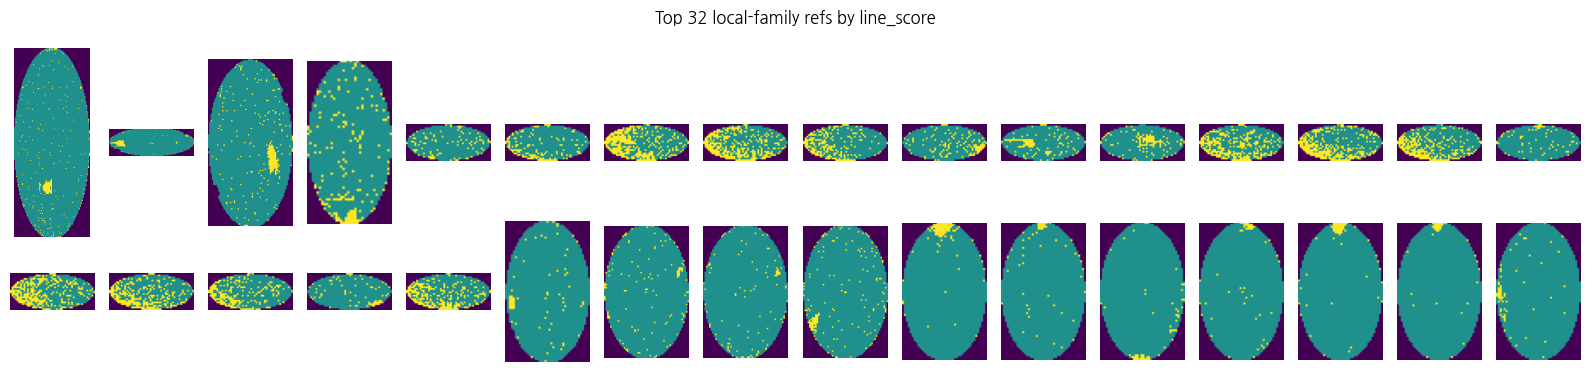

In [54]:
# local_ref_feat(또는 line_score)로 가장 "선스러운" ref를 직접 시각화
# 지금은 네가 이미 가진 line_score를 ref에 적용해서 quick check

ref_scores = []
for ref_i in local_ref_emb_idx:
    rloc = int(ref_local_idx[ref_i])
    wm = ref_df.iloc[rloc]["waferMap"]
    ref_scores.append(line_score(wm))
ref_scores = np.array(ref_scores)

top = np.argsort(-ref_scores)[:32]
top_ref = local_ref_emb_idx[top]

plt.figure(figsize=(16,4))
for j, ref_i in enumerate(top_ref):
    rloc = int(ref_local_idx[ref_i])
    wm = ref_df.iloc[rloc]["waferMap"]
    plt.subplot(2,16,j+1)
    plt.imshow(wm); plt.axis("off")
plt.suptitle("Top 32 local-family refs by line_score")
plt.tight_layout()
plt.show()

### 10.9 트리아지 요약 한 줄 (발표용)

In [50]:
from collections import Counter

def _unk_row_by_embidx(unk_i):
    # unk_i(임베딩 인덱스) -> test_unknown_df 위치
    return test_unknown_df.iloc[int(unk_local_idx[unk_i])]

def _ref_row_by_embidx(ref_i):
    # ref_i(임베딩 인덱스) -> ref_df 위치
    return ref_df.iloc[int(ref_local_idx[ref_i])]

def triage_summary_from_refidx(ref_indices, K=5):
    labels = [_ref_row_by_embidx(j)["label"] for j in ref_indices[:K]]
    cnt = Counter(labels)
    top_label, top_count = cnt.most_common(1)[0]
    purity = top_count / K
    uniq = len(cnt)

    if purity >= 0.8:
        msg = f"Top-{K} 중 {top_label} {top_count}/{K} → '{top_label}' 계열 가능성 높음"
    elif uniq >= 4:
        msg = f"Top-{K} 라벨 다양({dict(cnt)}) → 애매 케이스(추가 확인/재측정 권장)"
    else:
        msg = f"Top-{K} 혼재({dict(cnt)}) → 유사 패턴 후보 복수"
    return labels, msg

def triage_summary(unk_i, K=5):
    # 글로벌 Top-K 요약
    return triage_summary_from_refidx(topk_idx[unk_i], K)

### 10.10 데모 화면 출력 (Unknown + Top-K)

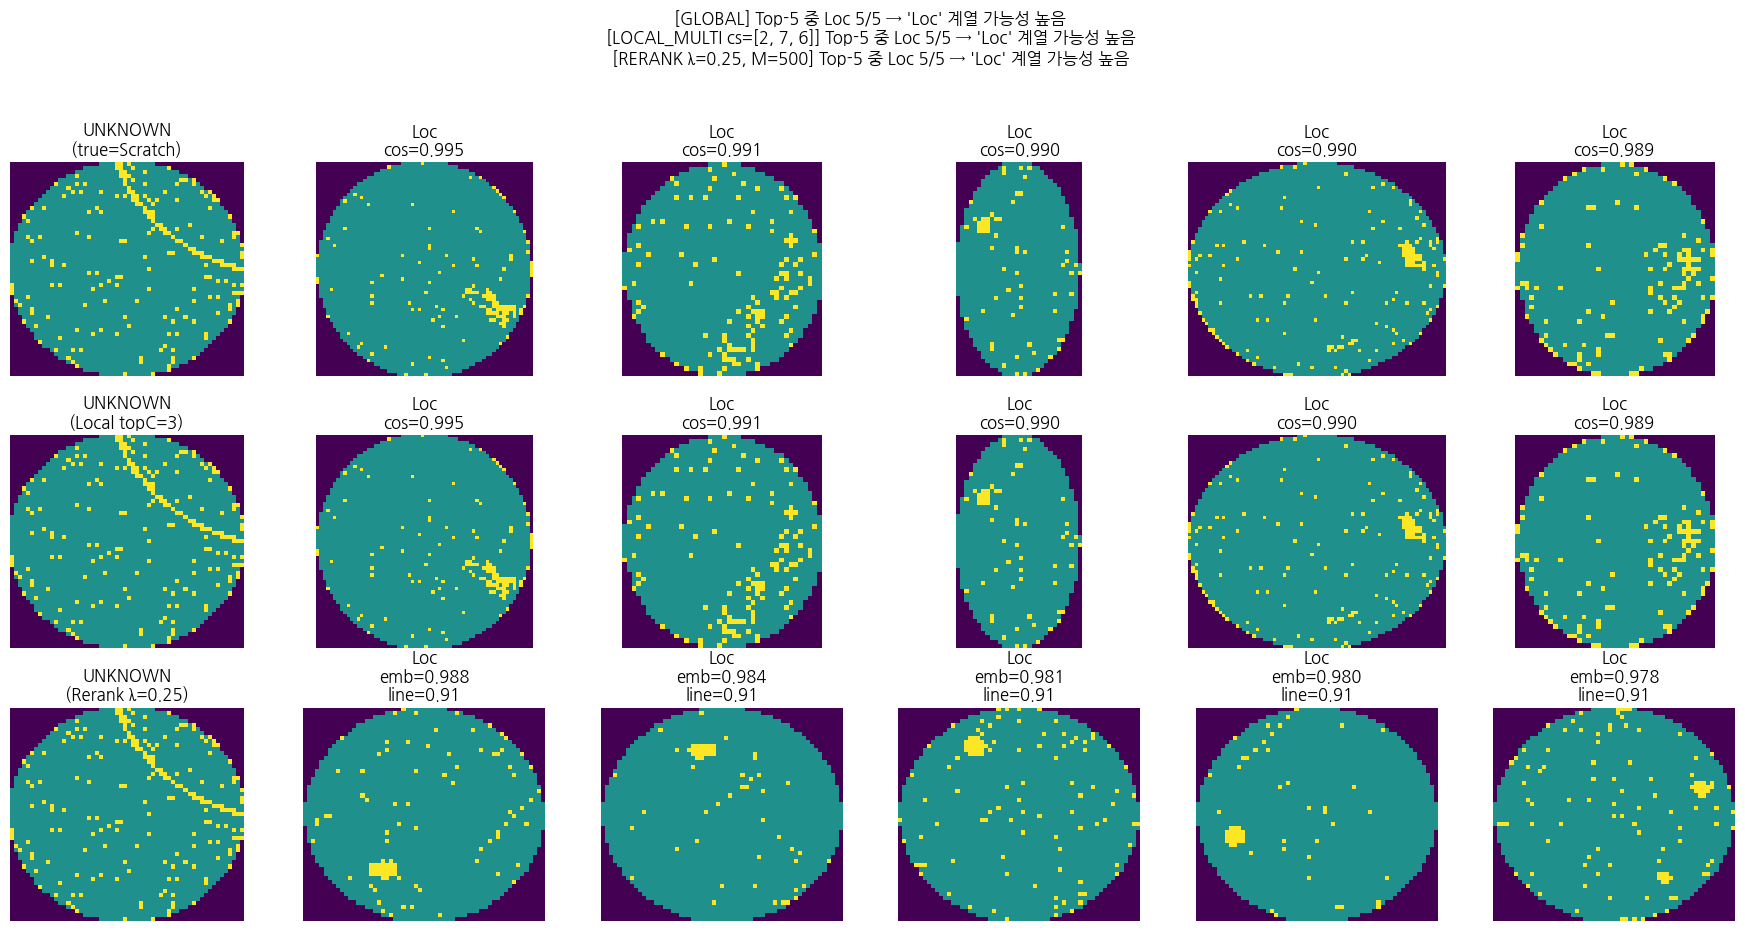

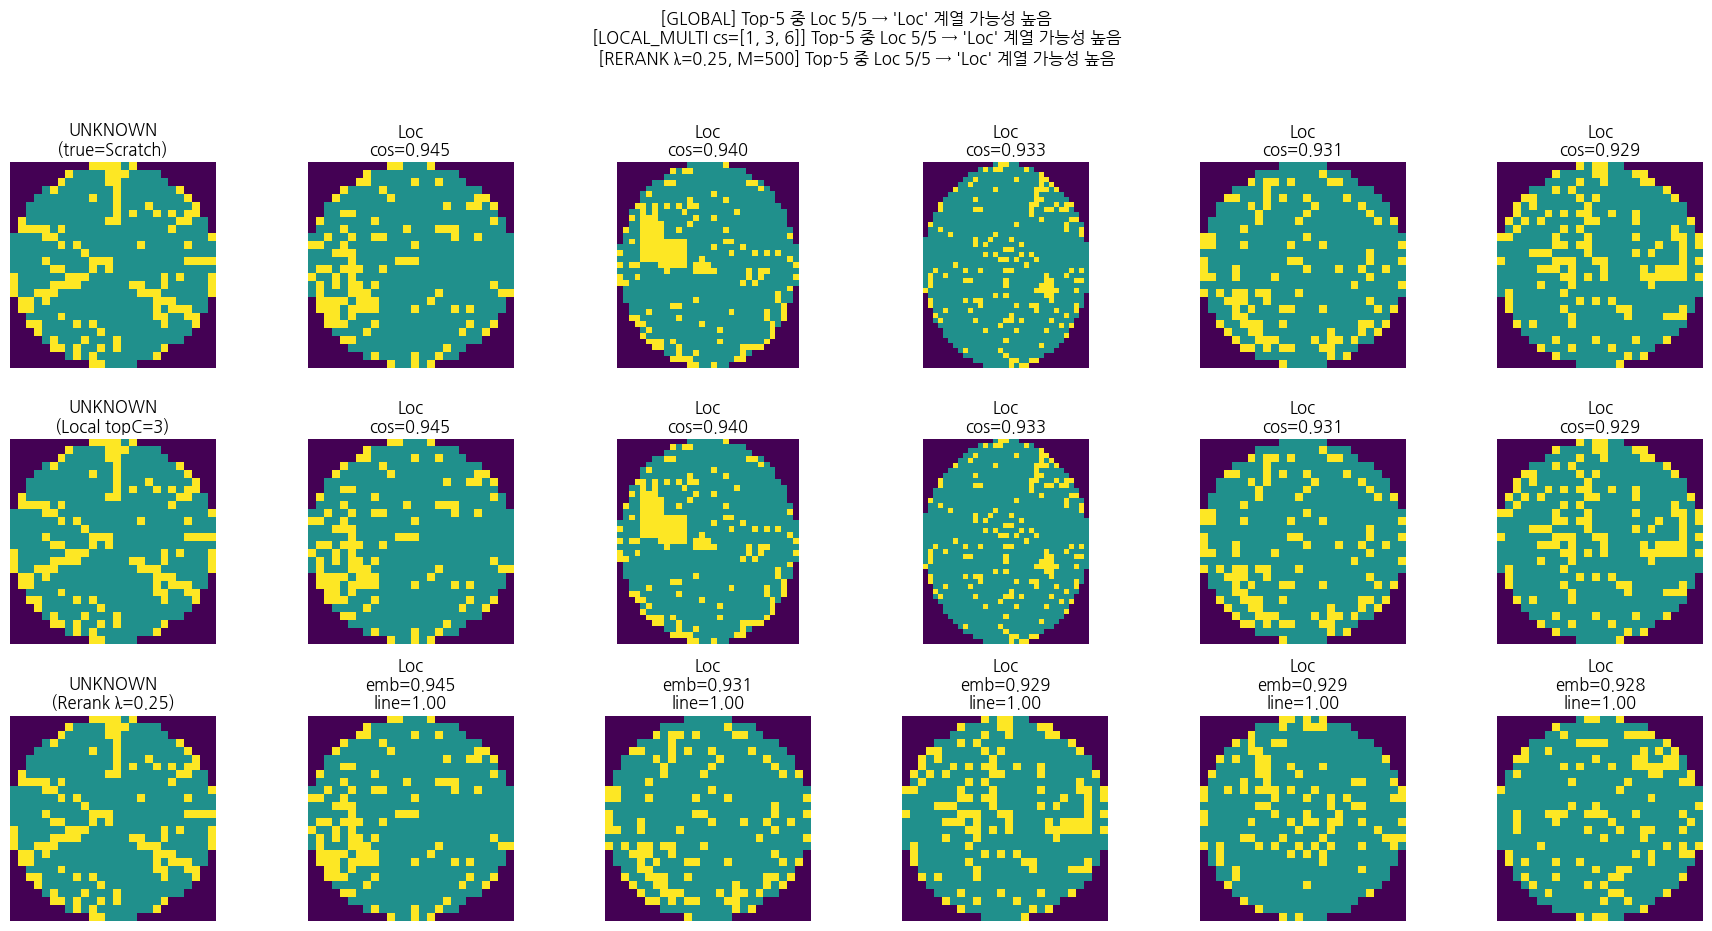

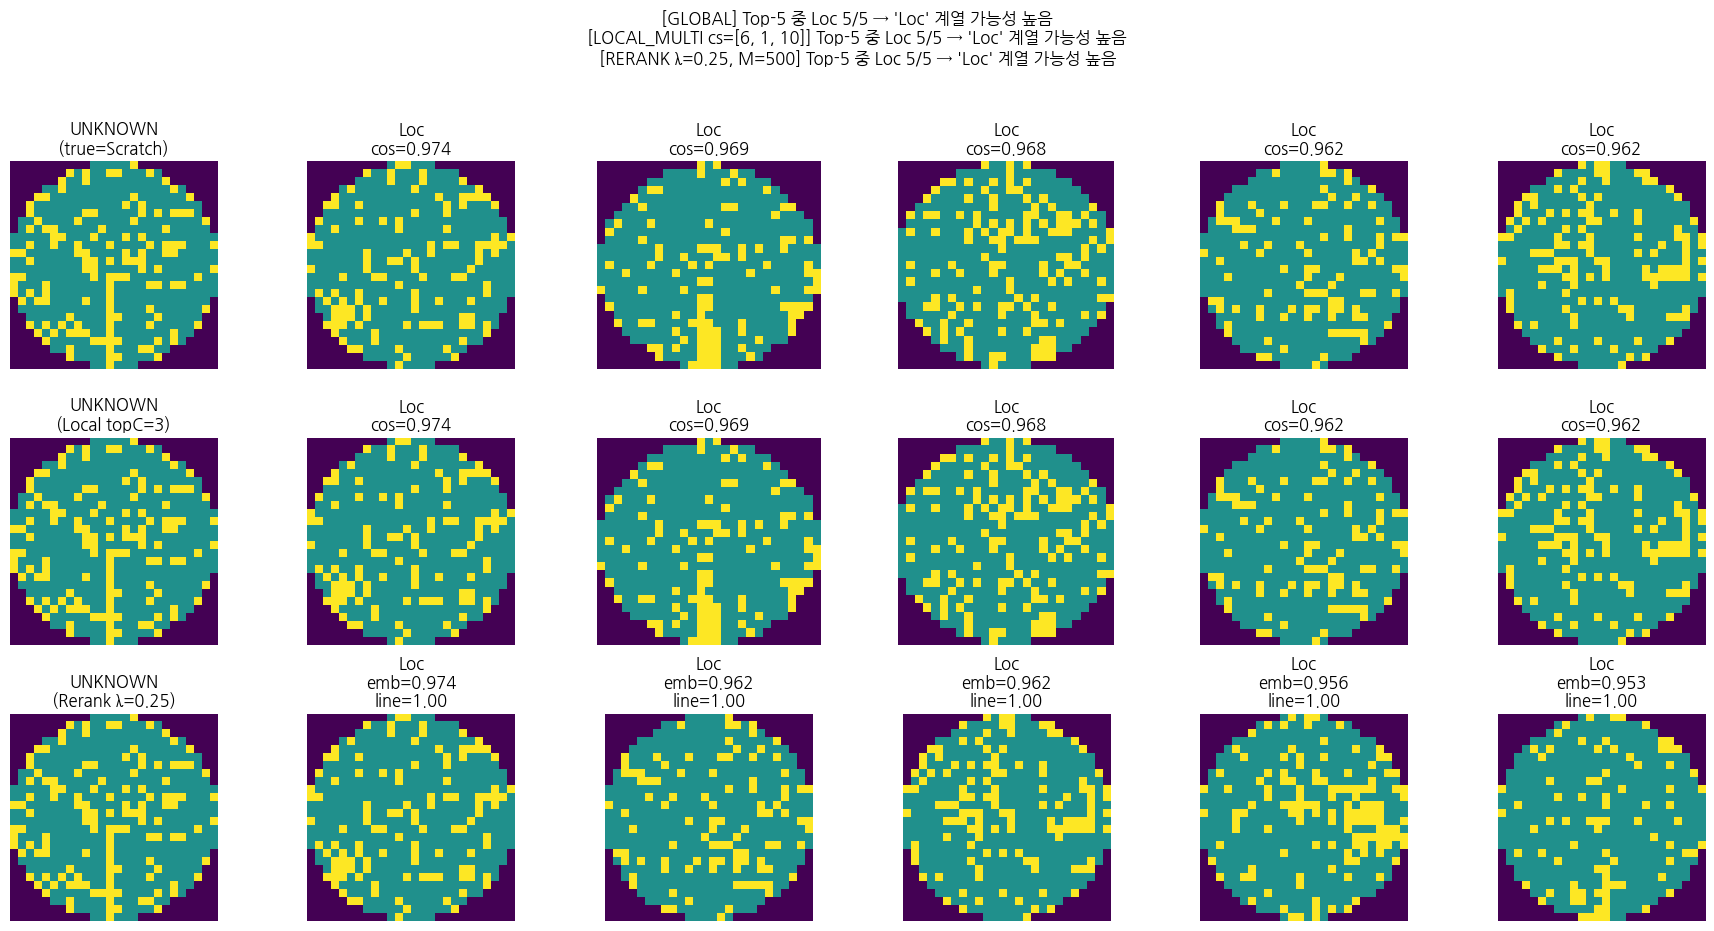

In [51]:
import matplotlib.pyplot as plt

def show_triage_case_3way(unk_i, K=5, topC=3, lam=0.25, M=500):
    unk_row = _unk_row_by_embidx(unk_i)
    unk_wm = unk_row["waferMap"]
    true_label = unk_row["label"] if "label" in unk_row else "unknown"

    # (1) Global
    g_ref_idx = topk_idx[unk_i][:K]
    g_ref_sim = topk_sim[unk_i][:K]
    _, g_msg = triage_summary_from_refidx(g_ref_idx, K)

    # (2) Local multi-cluster pooling
    top_cs, lm_ref_idx, lm_ref_sim = local_cluster_topk_multi(unk_i, k=K, topC=topC)
    _, lm_msg = triage_summary_from_refidx(lm_ref_idx, K)

    # (3) Rerank (local-family Top-M -> line rerank)
    rr_ref_idx, rr_emb_sim, rr_feat_sim = rerank_topK(unk_i, M=M, K=K, lam=lam)
    _, rr_msg = triage_summary_from_refidx(rr_ref_idx, K)

    rows = 3
    plt.figure(figsize=(3*(K+1), 3*rows))

    # ----- Row 1: Global -----
    plt.subplot(rows, K+1, 1)
    plt.imshow(unk_wm); plt.axis("off")
    plt.title(f"UNKNOWN\n(true={true_label})")

    for j in range(K):
        rrow = _ref_row_by_embidx(g_ref_idx[j])
        plt.subplot(rows, K+1, j+2)
        plt.imshow(rrow["waferMap"]); plt.axis("off")
        plt.title(f"{rrow['label']}\ncos={g_ref_sim[j]:.3f}")

    # ----- Row 2: Local multi -----
    plt.subplot(rows, K+1, (K+1)+1)
    plt.imshow(unk_wm); plt.axis("off")
    plt.title(f"UNKNOWN\n(Local topC={topC})")

    for j in range(K):
        rrow = _ref_row_by_embidx(lm_ref_idx[j])
        plt.subplot(rows, K+1, (K+1)+j+2)
        plt.imshow(rrow["waferMap"]); plt.axis("off")
        plt.title(f"{rrow['label']}\ncos={lm_ref_sim[j]:.3f}")

    # ----- Row 3: Rerank -----
    plt.subplot(rows, K+1, 2*(K+1)+1)
    plt.imshow(unk_wm); plt.axis("off")
    plt.title(f"UNKNOWN\n(Rerank λ={lam})")

    for j in range(K):
        rrow = _ref_row_by_embidx(rr_ref_idx[j])
        plt.subplot(rows, K+1, 2*(K+1)+j+2)
        plt.imshow(rrow["waferMap"]); plt.axis("off")
        plt.title(f"{rrow['label']}\nemb={rr_emb_sim[j]:.3f}\nline={rr_feat_sim[j]:.2f}")

    plt.suptitle(
        f"[GLOBAL] {g_msg}\n"
        f"[LOCAL_MULTI cs={top_cs}] {lm_msg}\n"
        f"[RERANK λ={lam}, M={M}] {rr_msg}",
        y=1.03, fontsize=12
    )
    plt.tight_layout()
    plt.show()

# 예시 실행 (원하는 unk index로 바꿔서 보기)
for i in [0, 1, 2]:
    show_triage_case_3way(i, K=5, topC=3, lam=0.25, M=500)

### 10.11 데모 결과 저장 (이미지/요약)

In [53]:
import os
import matplotlib.pyplot as plt

OUT_DIR = "assets/triage"
os.makedirs(OUT_DIR, exist_ok=True)

def save_triage_case(unk_i, K=5, show_local=True):
    unk_row = _unk_row_by_embidx(unk_i)
    true_label = unk_row["label"] if "label" in unk_row else "unknown"

    # global
    g_ref_idx = topk_idx[unk_i][:K]
    g_ref_sim = topk_sim[unk_i][:K]
    _, g_msg = triage_summary_from_refidx(g_ref_idx, K)

    # local
    if show_local:
        c_id, l_ref_idx, l_ref_sim = local_cluster_topk(unk_i, k=K)
        _, l_msg = triage_summary_from_refidx(l_ref_idx, K)
    else:
        c_id, l_ref_idx, l_ref_sim, l_msg = None, None, None, ""

    rows = 2 if show_local else 1
    plt.figure(figsize=(3*(K+1), 3*rows))

    # row 1
    plt.subplot(rows, K+1, 1)
    plt.imshow(unk_row["waferMap"]); plt.axis("off")
    plt.title(f"UNKNOWN\n(true={true_label})")
    for j in range(K):
        rrow = _ref_row_by_embidx(g_ref_idx[j])
        plt.subplot(rows, K+1, j+2)
        plt.imshow(rrow["waferMap"]); plt.axis("off")
        plt.title(f"{rrow['label']}\ncos={g_ref_sim[j]:.3f}")

    # row 2
    if show_local:
        plt.subplot(rows, K+1, (K+1)+1)
        plt.imshow(unk_row["waferMap"]); plt.axis("off")
        plt.title(f"UNKNOWN\n(Local c={c_id})")
        for j in range(K):
            rrow = _ref_row_by_embidx(l_ref_idx[j])
            plt.subplot(rows, K+1, (K+1)+j+2)
            plt.imshow(rrow["waferMap"]); plt.axis("off")
            plt.title(f"{rrow['label']}\ncos={l_ref_sim[j]:.3f}")

    plt.suptitle(f"[GLOBAL] {g_msg}" + (f"\n[LOCAL c={c_id}] {l_msg}" if show_local else ""), y=1.03, fontsize=12)
    plt.tight_layout()

    fname = f"triage_unk{unk_i:04d}_true-{true_label}"
    if show_local:
        fname += f"_c{c_id:02d}"
    fname += ".png"

    path = os.path.join(OUT_DIR, fname)
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.close()
    return path, g_msg

# 6개만 저장
picked = [0, 1, 2, 3, 4, 5]
for i in picked:
    p, m = save_triage_case(i, K=5, show_local=True)
    print(p, "|", m)


assets/triage/triage_unk0000_true-Scratch_c02.png | Top-5 중 Loc 5/5 → 'Loc' 계열 가능성 높음
assets/triage/triage_unk0001_true-Scratch_c01.png | Top-5 중 Loc 5/5 → 'Loc' 계열 가능성 높음
assets/triage/triage_unk0002_true-Scratch_c06.png | Top-5 중 Loc 5/5 → 'Loc' 계열 가능성 높음
assets/triage/triage_unk0003_true-Scratch_c01.png | Top-5 중 Loc 5/5 → 'Loc' 계열 가능성 높음
assets/triage/triage_unk0004_true-Scratch_c04.png | Top-5 혼재({'Center': 3, 'Loc': 2}) → 유사 패턴 후보 복수
assets/triage/triage_unk0005_true-Scratch_c04.png | Top-5 중 Loc 5/5 → 'Loc' 계열 가능성 높음


### 10.12 (선택) OOD 점수로 데모 후보 자동 선별

이미 unknown에 대한 MSP/Energy 배열을 갖고 있으면 이 셀은 건너뛰어도 됨.

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# 전제: model(or loaded_model), device, test_unknown_df, WaferMapDataset(혹은 너가 쓰는 Dataset)이 존재
model_use = loaded_model if "loaded_model" in globals() else model_use if "model_use" in globals() else model
model_use = model_use.to(device).eval()

INPUT_MODE = "coords4" if model_use.conv1.in_channels == 4 else "repeat3"
print("model in_ch:", model_use.conv1.in_channels, "=> INPUT_MODE:", INPUT_MODE)

# unknown loader (순서 보존 위해 shuffle=False)
unk_score_loader = DataLoader(
    WaferMapDataset(test_unknown_df, class_to_idx=None, is_train=False, resize=64, input_mode=INPUT_MODE),
    batch_size=256, shuffle=False, num_workers=2
)

@torch.no_grad()
def compute_msp_energy(model, loader):
    msps = []
    energy_raw = []  # Energy = -logsumexp(logits). OOD일수록 값이 덜 음수(=더 큼)로 가는 경향
    for batch in loader:
        # loader가 x만 주는 경우 / (x,idx) 주는 경우를 모두 처리
        x = batch[0] if isinstance(batch, (list, tuple)) else batch
        x = x.to(device)
        logits = model(x)

        prob = F.softmax(logits, dim=1)
        msp = prob.max(dim=1).values

        e = -torch.logsumexp(logits, dim=1)  # energy_raw
        msps.append(msp.cpu().numpy())
        energy_raw.append(e.cpu().numpy())

    msps = np.concatenate(msps)
    energy_raw = np.concatenate(energy_raw)
    return msps, energy_raw

msp_u, energy_u = compute_msp_energy(model_use, unk_score_loader)
print("scores:", msp_u.shape, energy_u.shape, "len(df)=", len(test_unknown_df))

### 10.13 데모 후보 자동 선택 기준

*   (A) unknown스러운 샘플: MSP 낮고, Energy_raw는 큰(덜 음수) 샘플
*   (B) 위험 샘플(과신): MSP 높은데도 실제론 unknown인 샘플 (과신 오분류 위험 강조용)

In [ ]:
N_DEMO = 8  # 저장할 케이스 개수

# A) unknown-likely: MSP 낮은 순 + Energy_raw 큰 순을 rank로 합침
rank_msp = np.argsort(msp_u)                 # 낮을수록 unknown
rank_e   = np.argsort(-energy_u)             # 클수록 unknown (덜 음수)
rank_sum = np.empty_like(rank_msp)
rank_sum[rank_msp] = np.arange(len(rank_msp))
rank_sum += np.arange(len(rank_e))[np.argsort(rank_e)]  # 간단 합산

demo_unknownlike = np.argsort(rank_sum)[:N_DEMO]

# B) overconfident unknown: MSP 높은 순
demo_overconf = np.argsort(-msp_u)[:min(N_DEMO, 5)]

print("demo_unknownlike:", demo_unknownlike)
print("demo_overconf:", demo_overconf)

### 10.14 트리아지 결과 저장 (그림 + CSV 요약)

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

OUT_DIR = "assets/triage"
os.makedirs(OUT_DIR, exist_ok=True)

def triage_summary(unk_i, K=5):
    labels = [ref_df.iloc[j]["label"] for j in topk_idx[unk_i][:K]]
    cnt = Counter(labels)
    top_label, top_count = cnt.most_common(1)[0]
    purity = top_count / K
    uniq = len(cnt)

    if purity >= 0.8:
        msg = f"Top-{K}: {top_label} {top_count}/{K} → '{top_label}' 계열 가능성 높음"
    elif uniq >= 4:
        msg = f"Top-{K} 라벨 다양({dict(cnt)}) → 애매 케이스(추가 확인/재측정 권장)"
    else:
        msg = f"Top-{K} 혼재({dict(cnt)}) → 후보 복수"
    return labels, purity, msg

def save_triage_case(unk_i, K=5, extra_note=""):
    unk_row = test_unknown_df.iloc[unk_i]
    labels, purity, msg = triage_summary(unk_i, K)

    plt.figure(figsize=(3*(K+1), 3))
    plt.subplot(1, K+1, 1)
    plt.imshow(unk_row["waferMap"])
    plt.title(f"UNKNOWN\n(true={unk_row['label']})")
    plt.axis("off")

    for j in range(K):
        rrow = ref_df.iloc[topk_idx[unk_i][j]]
        plt.subplot(1, K+1, j+2)
        plt.imshow(rrow["waferMap"])
        plt.title(f"{rrow['label']}\ncos={topk_sim[unk_i][j]:.3f}")
        plt.axis("off")

    title = msg + (f" | {extra_note}" if extra_note else "")
    plt.suptitle(title, y=1.05, fontsize=11)
    plt.tight_layout()

    fname = f"triage_unk{unk_i:04d}_true-{unk_row['label']}.png"
    path = os.path.join(OUT_DIR, fname)
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.close()

    return {
        "unk_i": int(unk_i),
        "true_label": unk_row["label"],
        "topk_labels": "|".join(labels),
        "purity": float(purity),
        "note": title,
        "img_path": path
    }

def save_demo_set(indices, tag, K=5):
    rows = []
    for i in indices:
        extra = f"{tag}"
        rows.append(save_triage_case(int(i), K=K, extra_note=extra))
    return rows

# demo_unknownlike / demo_overconf가 없으면(위 셀 스킵했으면) 직접 indices를 넣어도 됨
K = 5
rows_all = []
if "demo_unknownlike" in globals():
    rows_all += save_demo_set(demo_unknownlike, "OOD-unknownlike", K=K)
if "demo_overconf" in globals():
    rows_all += save_demo_set(demo_overconf, "OOD-overconfident", K=K)

df_sum = pd.DataFrame(rows_all)

# OOD 점수도 같이 저장(있으면)
if "msp_u" in globals():
    df_sum["msp"] = df_sum["unk_i"].apply(lambda i: float(msp_u[i]))
if "energy_u" in globals():
    df_sum["energy_raw"] = df_sum["unk_i"].apply(lambda i: float(energy_u[i]))

csv_path = os.path.join(OUT_DIR, "triage_summary.csv")
df_sum.to_csv(csv_path, index=False, encoding="utf-8-sig")

print("✅ saved images to:", OUT_DIR)
print("✅ saved summary csv:", csv_path)
df_sum.head()

### 10.15 Unknown → Unknown 유사사례 Top-K (Nearest Neighbors)

지금까지는 **Unknown → Known(레퍼런스) Top-K**로,
Unknown이 “기존에 알려진 결함 중 무엇과 비슷한지”를 보여주는 트리아지였습니다.

다음 단계에서는 **Unknown끼리(Unknown → Unknown) 유사사례 Top-K**를 추가합니다.

- 목적: unknown이 “1회성”인지, “비슷한 패턴이 반복(재발)되는지” 빠르게 확인
- 입력: `unk_emb`, `test_unknown_df`
- 출력: query unknown 1장 + 가장 유사한 unknown K장(코사인 유사도)

> 시연/작품 톤을 살리려면 `true label` 표시는 숨기고(옵션), 모양 기반으로만 판단하게 구성합니다.

#### 10.15.1 unknown → unknown “가장 비슷한 샘플 Top-K” (Nearest Neighbors)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import os

def l2norm(a):
    return a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-12)

unk_n = l2norm(unk_emb).astype(np.float32)

# cosine distance 기반 최근접 이웃
K_NN = 6  # 자기 자신 포함해서 6개 -> 나중에 self 제외하면 5개
knn = NearestNeighbors(n_neighbors=K_NN, metric="cosine")
knn.fit(unk_n)

dist, idx = knn.kneighbors(unk_n)  # dist 낮을수록 유사(가까움), idx: (N_unk, K_NN)
# cosine similarity로 보고 싶으면 sim = 1 - dist
sim = 1.0 - dist

print("idx shape:", idx.shape, "sim shape:", sim.shape)


#### 10.15.2 unknown 유사사례 화면 출력

발표/데모에선 show_true_label=False로 숨기면 “진짜 unknown 트리아지” 느낌이 더 살음

In [ ]:
def show_unknown_neighbors(unk_i, K_show=5, show_true_label=True):
    # 첫 번째 이웃은 자기 자신일 가능성이 큼 -> 제외
    neigh = idx[unk_i]
    neigh_sim = sim[unk_i]

    # self 제외(동일 인덱스)
    pairs = [(j, s) for j, s in zip(neigh, neigh_sim) if j != unk_i]
    pairs = pairs[:K_show]

    plt.figure(figsize=(3*(K_show+1), 3))
    row = test_unknown_df.iloc[unk_i]
    plt.subplot(1, K_show+1, 1)
    plt.imshow(row["waferMap"])
    title = "UNKNOWN(query)"
    if show_true_label and "label" in row:
        title += f"\n(true={row['label']})"
    plt.title(title)
    plt.axis("off")

    for t, (j, s) in enumerate(pairs):
        r = test_unknown_df.iloc[int(j)]
        plt.subplot(1, K_show+1, t+2)
        plt.imshow(r["waferMap"])
        title = f"unk#{int(j)}\ncos={float(s):.3f}"
        if show_true_label and "label" in r:
            title += f"\n(true={r['label']})"
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 예시
for i in [0, 1, 2]:
    show_unknown_neighbors(i, K_show=5, show_true_label=True)


#### 10.15.3 unknown 클러스터링 (DBSCAN: “비슷한 애들끼리 자동 그룹핑”)

KMeans는 “군집 개수 K를 미리 정해야” 해서 MVP-2에는 덜 직관적이고,  
DBSCAN은 “밀도 기반”이라 신규 패턴 후보군 만들 때 스토리가 좋음.

In [ ]:
from sklearn.cluster import DBSCAN
from collections import Counter

# cosine distance 기준 eps는 데이터마다 달라서 0.15~0.35 정도를 먼저 시도
eps = 0.25
min_samples = 10

db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
unk_cluster = db.fit_predict(unk_n)  # -1은 noise(어느 군집에도 안 들어감)

cnt = Counter(unk_cluster)
print("cluster counts:", cnt)
print("num clusters (excluding -1):", len([k for k in cnt.keys() if k != -1]))

eps를 3개만 빠르게 스윕해서 “너무 다 -1”인지 확인

In [ ]:
for eps_try in [0.20, 0.25, 0.30]:
    db = DBSCAN(eps=eps_try, min_samples=min_samples, metric="cosine")
    cl = db.fit_predict(unk_n)
    c = Counter(cl)
    ncl = len([k for k in c.keys() if k != -1])
    print(f"eps={eps_try:.2f} | clusters={ncl} | noise={c.get(-1,0)} / {len(cl)}")

#### 10.15.4 군집별 대표 샘플 + 유사 샘플 저장(포스터/슬라이드 바로 사용)

군집 대표(centroid에 가장 가까운 샘플) 찾기

In [ ]:
import numpy as np

def cluster_representatives(emb, cluster_ids):
    reps = {}
    for cid in sorted(set(cluster_ids)):
        if cid == -1:
            continue
        members = np.where(cluster_ids == cid)[0]
        if len(members) == 0:
            continue
        # centroid
        c = emb[members].mean(axis=0, keepdims=True)
        c = l2norm(c)[0]
        # centroid와 cosine similarity 최대인 샘플
        sims = emb[members] @ c
        rep = members[np.argmax(sims)]
        reps[cid] = int(rep)
    return reps

reps = cluster_representatives(unk_n, unk_cluster)
print("representatives:", reps)

군집 대표 + 같은 군집 Top-K 이웃을 한 장으로 저장

In [ ]:
OUT_DIR = "assets/triage_unknown"
os.makedirs(OUT_DIR, exist_ok=True)

def save_cluster_panel(cid, rep_i, K_show=5, show_true_label=True):
    # rep_i의 이웃 중 같은 군집만 추림
    neigh = idx[rep_i]
    neigh_sim = sim[rep_i]
    pairs = []
    for j, s in zip(neigh, neigh_sim):
        j = int(j)
        if j == rep_i:
            continue
        if unk_cluster[j] == cid:
            pairs.append((j, float(s)))
        if len(pairs) >= K_show:
            break

    plt.figure(figsize=(3*(K_show+1), 3))
    rep_row = test_unknown_df.iloc[rep_i]
    plt.subplot(1, K_show+1, 1)
    plt.imshow(rep_row["waferMap"])
    title = f"cluster {cid}\nrep unk#{rep_i}"
    if show_true_label and "label" in rep_row:
        title += f"\n(true={rep_row['label']})"
    plt.title(title)
    plt.axis("off")

    for t, (j, s) in enumerate(pairs):
        r = test_unknown_df.iloc[j]
        plt.subplot(1, K_show+1, t+2)
        plt.imshow(r["waferMap"])
        title = f"unk#{j}\ncos={s:.3f}"
        if show_true_label and "label" in r:
            title += f"\n(true={r['label']})"
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    path = os.path.join(OUT_DIR, f"unknown_cluster{cid}_rep{rep_i}.png")
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.close()
    return path

saved = []
for cid, rep_i in list(reps.items())[:8]:  # 최대 8개 군집만 저장(조절 가능)
    saved.append(save_cluster_panel(cid, rep_i, K_show=5, show_true_label=True))

print("saved:", len(saved), "files in", OUT_DIR)

요약 CSV 저장 (군집 크기/대표/라벨 분포)

In [ ]:
import pandas as pd
from collections import Counter

rows = []
for cid in sorted(set(unk_cluster)):
    members = np.where(unk_cluster == cid)[0]
    if len(members) == 0:
        continue
    row = {"cluster_id": int(cid), "count": int(len(members))}
    if cid != -1 and cid in reps:
        row["rep_unk_i"] = reps[cid]
    # 개발 중에는 true label 분포도 같이 기록(최종 데모에선 숨겨도 됨)
    if "label" in test_unknown_df.columns:
        labels = test_unknown_df.iloc[members]["label"].tolist()
        row["label_dist"] = dict(Counter(labels))
    rows.append(row)

df_cl = pd.DataFrame(rows).sort_values(["cluster_id"])
csv_path = os.path.join(OUT_DIR, "unknown_clusters_summary.csv")
df_cl.to_csv(csv_path, index=False, encoding="utf-8-sig")
csv_path, df_cl.head()

### 10.16 Top-K 기반 ‘후보군’ 클러스터링

#### 10.16.1 unknown을 “Top-K 라벨 분포 벡터”로 변환

예: known 클래스가 7개면 unknown 하나를 7차원 벡터로 만듦
(Top-K에서 Loc가 3개면 Loc 차원에 3/5 같은 값)

In [ ]:
import numpy as np
from collections import Counter

known_labels = sorted(ref_df["label"].unique())
label_to_j = {c:j for j,c in enumerate(known_labels)}
K = topk_idx.shape[1]

def topk_label_vector(i):
    labels = [ref_df.iloc[j]["label"] for j in topk_idx[i]]
    cnt = Counter(labels)
    v = np.zeros(len(known_labels), dtype=np.float32)
    for lab, n in cnt.items():
        v[label_to_j[lab]] = n / K
    return v, cnt, labels

X_triage = np.stack([topk_label_vector(i)[0] for i in range(len(test_unknown_df))], axis=0)
print("X_triage shape:", X_triage.shape)  # (N_unknown, num_known_classes)

#### 10.16.2 KMeans로 “Top-K 패턴 그룹” 만들기

In [ ]:
from sklearn.cluster import KMeans
from collections import Counter

n_clusters = 6
km = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init="auto")
triage_cluster = km.fit_predict(X_triage)

print("cluster counts:", Counter(triage_cluster))

#### 10.16.3 군집을 사람이 읽기 쉬운 말로 요약

각 군집에서 “Top-K가 주로 어느 라벨로 쏠리는지”를 요약해줌.

예시 출력 해석:  
Loc 0.62, Edge-Loc 0.21 …  
→ “이 그룹은 Top-K가 Loc 쪽으로 강하게 몰림”

In [ ]:
def summarize_cluster(cid, topn=3):
    members = np.where(triage_cluster == cid)[0]
    mean_v = X_triage[members].mean(axis=0)  # 평균 분포
    top = mean_v.argsort()[::-1][:topn]
    return [(known_labels[j], float(mean_v[j])) for j in top], len(members)

for cid in range(n_clusters):
    top, n = summarize_cluster(cid, topn=3)
    print(f"[cluster {cid}] n={n} | top:", top)

#### 10.16.4 군집 대표 unknown 뽑고, “Top-K 패널” 자동 저장
대표는 “군집 평균 분포(mean_v)와 가장 가까운 unknown”으로 선택.

In [ ]:
import os
import matplotlib.pyplot as plt

OUT_DIR = "assets/triage_clusters"
os.makedirs(OUT_DIR, exist_ok=True)

def pick_representative(cid):
    members = np.where(triage_cluster == cid)[0]
    mean_v = X_triage[members].mean(axis=0, keepdims=True)
    # cosine similarity로 가장 가까운 멤버 선택
    A = members
    num = (X_triage[A] @ mean_v.T).squeeze()
    den = (np.linalg.norm(X_triage[A], axis=1) * np.linalg.norm(mean_v) + 1e-12)
    cos = num / den
    return int(A[np.argmax(cos)])

def save_topk_panel(unk_i, K=5, title_prefix=""):
    unk_row = test_unknown_df.iloc[unk_i]

    plt.figure(figsize=(3*(K+1), 3))
    plt.subplot(1, K+1, 1)
    plt.imshow(unk_row["waferMap"])
    plt.title(f"UNKNOWN\n(true={unk_row['label']})")
    plt.axis("off")

    for j in range(K):
        rrow = ref_df.iloc[topk_idx[unk_i][j]]
        plt.subplot(1, K+1, j+2)
        plt.imshow(rrow["waferMap"])
        plt.title(f"{rrow['label']}\ncos={topk_sim[unk_i][j]:.3f}")
        plt.axis("off")

    plt.suptitle(title_prefix, y=1.05, fontsize=11)
    plt.tight_layout()
    path = os.path.join(OUT_DIR, f"clusterPanel_unk{unk_i:04d}.png")
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.close()
    return path

saved = []
for cid in range(n_clusters):
    rep = pick_representative(cid)
    top, n = summarize_cluster(cid, topn=3)
    title = f"Cluster {cid} (n={n}) | top={top}"
    saved.append(save_topk_panel(rep, K=K, title_prefix=title))

print("saved panels:", len(saved), "in", OUT_DIR)

#### 10.16.5 요약 CSV 저장

In [ ]:
import pandas as pd
from collections import Counter

rows = []
for cid in range(n_clusters):
    members = np.where(triage_cluster == cid)[0]
    rep = pick_representative(cid)
    top, n = summarize_cluster(cid, topn=5)
    rows.append({
        "cluster_id": cid,
        "count": n,
        "rep_unk_i": rep,
        "top_known_mix": top
    })

df_clusters = pd.DataFrame(rows)
csv_path = os.path.join(OUT_DIR, "triage_clusters_summary.csv")
df_clusters.to_csv(csv_path, index=False, encoding="utf-8-sig")
csv_path, df_clusters

## 11. 결과 보고서

In [ ]:
# =========================
# REPORT (robust, single cell)
# =========================
import os, json, subprocess, datetime, sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# -------------------------
# 0) 기본 경로
# -------------------------
PROJECT_DIR = "/content/drive/MyDrive/Colab Notebooks/WMI_Wafer_DefectPattern_Detection_AnomalyAnalysis"
OUT_ROOT = os.path.join(PROJECT_DIR, "reports")
os.makedirs(OUT_ROOT, exist_ok=True)

def _safe(s: str) -> str:
    s = str(s)
    bad = [' ', '/', '\\', ':', '[', ']', '{', '}', '(', ')', ',', '"', "'"]
    for b in bad:
        s = s.replace(b, "_")
    return s

def save_json(path, obj):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)

def save_txt(path, text):
    with open(path, "w") as f:
        f.write(text)

def get_git_hash():
    try:
        return subprocess.check_output(["git", "rev-parse", "--short", "HEAD"]).decode().strip()
    except Exception:
        return None

# -------------------------
# 1) 모델 선택 (여기서 절대 꼬이지 않게 강제)
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

model_use = None
model_source = None
if "model" in globals() and model is not None:
    model_use = model
    model_source = "model"
elif "loaded_model" in globals() and loaded_model is not None:
    model_use = loaded_model
    model_source = "loaded_model"

if model_use is None:
    raise RuntimeError("No model found. Need `model` or `loaded_model` in globals().")

model_use = model_use.to(device).eval()

# -------------------------
# 2) 라벨/매핑 확정 (잔존 변수 사용 금지)
# -------------------------
if "class_to_idx" not in globals() or class_to_idx is None:
    raise RuntimeError("class_to_idx not found.")
if "known_classes" not in globals() or known_classes is None:
    # class_to_idx로부터 known_classes 재구성
    known_classes = [None] * len(class_to_idx)
    for c, i in class_to_idx.items():
        known_classes[i] = c

# idx_to_class도 확정
idx_to_class_local = {i: c for c, i in class_to_idx.items()}

label_names = list(known_classes)  # 표시 순서
label_ids   = [class_to_idx[c] for c in label_names]  # 실제 y id

K = len(label_names)

# -------------------------
# 3) 사용된 입력 설정(기록용) 확정
#   우선순위: __LOADERS_CFG__ > MODEL_CFG > (INPUT_MODE/RESIZE)
# -------------------------
resize_used = None
input_mode_used = None

if "__LOADERS_CFG__" in globals() and __LOADERS_CFG__ is not None:
    # (__LOADERS_CFG__ = (RESIZE, INPUT_MODE, ...)) 형태
    try:
        resize_used = int(__LOADERS_CFG__[0])
        input_mode_used = str(__LOADERS_CFG__[1])
    except Exception:
        pass

if (resize_used is None or input_mode_used is None) and ("MODEL_CFG" in globals()) and isinstance(MODEL_CFG, dict):
    if resize_used is None and "resize" in MODEL_CFG:
        resize_used = int(MODEL_CFG["resize"])
    if input_mode_used is None and "input_mode" in MODEL_CFG:
        input_mode_used = str(MODEL_CFG["input_mode"])

if resize_used is None and "RESIZE" in globals():
    resize_used = int(RESIZE)
if input_mode_used is None and "INPUT_MODE" in globals():
    input_mode_used = str(INPUT_MODE)

# fallback
if resize_used is None:
    resize_used = 64
if input_mode_used is None:
    input_mode_used = "unknown_input_mode"

# -------------------------
# 4) OUT_DIR (run_id 생성)
#   - CKPT_PATH / best_path / last_path가 있으면 그 이름을 활용
# -------------------------
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

ckpt_ref = None
for cand in ["CKPT_PATH", "best_path", "last_path"]:
    if cand in globals() and globals()[cand]:
        ckpt_ref = globals()[cand]
        break

ckpt_base = _safe(os.path.basename(ckpt_ref)) if isinstance(ckpt_ref, str) else f"no_ckpt_{ts}"
run_id = f"{ts}_{_safe(getattr(model_use, '__class__', type(model_use)).__name__)}_R{resize_used}_{input_mode_used}_K{K}_{ckpt_base}".replace(".pt","").replace(".pth","").replace(".ckpt","")
OUT_DIR = os.path.join(OUT_ROOT, run_id)
os.makedirs(OUT_DIR, exist_ok=True)

print("✅ OUT_DIR:", OUT_DIR)

# -------------------------
# 5) TEST_KNOWN loader 존재 확인
# -------------------------
if "test_known_loader" not in globals() or test_known_loader is None:
    raise RuntimeError("test_known_loader not found. Make sure loaders are built before running report cell.")

# -------------------------
# 6) 배치 sanity + (중요) y가 idx로 들어오는 사고 감지
# -------------------------
xb, yb = next(iter(test_known_loader))
x_min, x_max = float(xb.min().item()), float(xb.max().item())

# yb가 Tensor/np/리스트 등 가능 -> numpy로 확인
if torch.is_tensor(yb):
    yb_np = yb.detach().cpu().numpy()
else:
    yb_np = np.array(yb)

print("[REPORT sanity]")
print(f"  model_source={model_source}  device={device}")
print(f"  input_mode_used={input_mode_used}  resize_used={resize_used}")
print(f"  batch_x={tuple(xb.shape)}  x_range=({x_min:.3f},{x_max:.3f})")
print(f"  batch_y_unique(sample)={np.unique(yb_np)[:10]}")

# y 값이 클래스 범위를 크게 벗어나면 (x, idx) 혹은 (x,y,idx)에서 y가 idx로 들어간 사고 가능성
if yb_np.size > 0 and (yb_np.max() >= K or yb_np.min() < 0):
    raise RuntimeError(
        f"y values look wrong (min={yb_np.min()}, max={yb_np.max()}, K={K}). "
        "Your loader might be returning (x, idx) or y is not class id."
    )

# -------------------------
# 7) 예측
# -------------------------
@torch.no_grad()
def predict_loader(model, loader):
    ys, ps = [], []
    for batch in loader:
        # (x,y) 또는 (x,y,idx) 모두 지원
        x = batch[0]
        y = batch[1]

        x = x.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1).detach().cpu().numpy()

        if torch.is_tensor(y):
            y_np = y.detach().cpu().numpy()
        else:
            y_np = np.array(y)

        ys.append(y_np)
        ps.append(pred)

    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    return y_true, y_pred

y_true, y_pred = predict_loader(model_use, test_known_loader)

acc   = accuracy_score(y_true, y_pred)
macro = f1_score(y_true, y_pred, average="macro")
pred_dist = np.bincount(y_pred, minlength=K).tolist()
true_dist = np.bincount(y_true, minlength=K).tolist()

rep = classification_report(
    y_true, y_pred,
    labels=label_ids,
    target_names=label_names,
    zero_division=0
)

# -------------------------
# 8) confusion matrix 저장/플롯
# -------------------------
cm_raw = confusion_matrix(y_true, y_pred, labels=label_ids)
cm_row = cm_raw / np.clip(cm_raw.sum(axis=1, keepdims=True), 1, None)

np.save(os.path.join(OUT_DIR, "cm_raw.npy"), cm_raw)
np.save(os.path.join(OUT_DIR, "cm_row_norm.npy"), cm_row)

plt.figure(figsize=(8, 6))
plt.imshow(cm_row, vmin=0, vmax=1)
plt.xticks(range(K), label_names, rotation=45, ha="right")
plt.yticks(range(K), label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (row-normalized)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "test_cm_row_norm.png"), dpi=200)
plt.close()
print("✅ saved test_cm_row_norm.png")

# -------------------------
# 9) report/meta 저장
# -------------------------
save_txt(
    os.path.join(OUT_DIR, "test_report.txt"),
    f"[TEST]\nacc={acc:.4f}, macroF1={macro:.4f}\n"
    f"true_dist={true_dist}\n"
    f"pred_dist={pred_dist}\n\n{rep}\n"
)
print("✅ saved test_report.txt")

meta = {
    "timestamp": ts,
    "out_dir": OUT_DIR,
    "model_source": model_source,
    "device": device,
    "torch": torch.__version__,
    "python": sys.version,
    "git_hash": get_git_hash(),
    "ckpt_ref": ckpt_ref if isinstance(ckpt_ref, str) else None,
    "resize_used": resize_used,
    "input_mode_used": input_mode_used,
    "conv1_in_channels": int(getattr(getattr(model_use, "conv1", None), "in_channels", -1)),
    "num_classes": K,
    "known_classes": label_names,
    "class_to_idx": dict(class_to_idx),
    "metrics": {
        "test_acc": float(acc),
        "test_macro_f1": float(macro),
        "true_dist": true_dist,
        "pred_dist": pred_dist,
        "x_range": [x_min, x_max],
        "x_shape": list(xb.shape),
    },
}

# 있으면 같이 기록
for k in ["RANDOM_STATE", "MODEL_CFG", "UNKNOWN_CLASSES", "EXCLUDE_CLASSES"]:
    if k in globals():
        try:
            meta[k.lower()] = globals()[k]
        except Exception:
            pass

save_json(os.path.join(OUT_DIR, "runmeta.json"), meta)
print("✅ saved runmeta.json")

# -------------------------
# 10) (옵션) 임베딩/UMAP 저장
# -------------------------
def try_save_npy(name, arr):
    try:
        np.save(os.path.join(OUT_DIR, f"{name}.npy"), arr)
        print(f"✅ saved {name}.npy", getattr(arr, "shape", None))
    except Exception as e:
        print(f"⚠️ skip save {name}.npy:", repr(e))

for name in ["ref_emb", "ref_y", "unk_emb"]:
    if name in globals():
        try_save_npy(name, globals()[name])

# UMAP은 설치 강제하지 않고, 있으면만 수행
def save_umap_known_unknown(ref_emb, ref_y, unk_emb, random_state, out_dir):
    import umap  # 없으면 ImportError
    N_REF_VIS = min(5000, len(ref_emb))
    N_UNK_VIS = min(2000, len(unk_emb))

    rng = np.random.RandomState(random_state if random_state is not None else 42)
    ref_vis_idx = rng.choice(len(ref_emb), size=N_REF_VIS, replace=False)
    unk_vis_idx = rng.choice(len(unk_emb), size=N_UNK_VIS, replace=False)

    X_vis = np.vstack([ref_emb[ref_vis_idx], unk_emb[unk_vis_idx]])
    y_vis = np.concatenate([ref_y[ref_vis_idx], -1*np.ones(N_UNK_VIS, dtype=int)])

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=(random_state if random_state is not None else 42))
    Z = reducer.fit_transform(X_vis)

    np.save(os.path.join(out_dir, "umap_Z.npy"), Z)
    np.save(os.path.join(out_dir, "umap_y.npy"), y_vis)

    plt.figure(figsize=(8,6))
    mask_unk = (y_vis == -1)
    plt.scatter(Z[mask_unk,0], Z[mask_unk,1], s=6, label="Unknown", alpha=0.9)
    for k in sorted(np.unique(y_vis)):
        if k == -1:
            continue
        m = (y_vis == k)
        name = idx_to_class_local.get(int(k), f"Class {int(k)}")
        plt.scatter(Z[m,0], Z[m,1], s=6, label=name, alpha=0.9)

    plt.title("Embedding 2D (UMAP): known vs unknown")
    plt.legend(markerscale=3, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "umap_known_unknown.png"), dpi=200)
    plt.close()
    print("✅ saved umap_known_unknown.png + umap_Z.npy + umap_y.npy")

if all(k in globals() for k in ["ref_emb", "ref_y", "unk_emb"]):
    try:
        rs = globals()["RANDOM_STATE"] if "RANDOM_STATE" in globals() else 42
        save_umap_known_unknown(ref_emb, ref_y, unk_emb, rs, OUT_DIR)
    except Exception as e:
        print("⚠️ skip UMAP:", repr(e))
else:
    print("⚠️ skip UMAP (need ref_emb, ref_y, unk_emb)")

print("DONE ✅")